In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
import pandas as pd
from IPython.display import Markdown, display
import praw
import prawcore
from time import sleep
from tqdm.notebook import tqdm
import json
import pandas as pd
from datetime import datetime
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
# !pip install langdetect
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from itertools import chain
import seaborn as sns
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import string
from tabulate import tabulate


# Suppress specific warning categories
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
nltk.download('stopwords')
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/avriowork/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-v0_8")

# Setting aesthetic parameters for plots
sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

In [ ]:
# with open("..\Data\combined.json", "r", encoding="utf-8") as f:
with open("/Users/avriowork/Documents/RMIT/SEM 2/social media/assignment_2/Social-Media-A2/Data/combined.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [14]:
df = pd.DataFrame(data)

In [15]:
# Count posts and comments
num_posts = df[df['type'] == 'submission'].shape[0]
num_comments = df[df['type'] == 'comment'].shape[0]

In [16]:
print(f"Total posts: {num_posts}")
print(f"Total comments: {num_comments}")

Total posts: 1945
Total comments: 37981


In [17]:
df.head(5)

,id,type,subreddit,title,selftext,created_utc,created,author,score,upvote_ratio,num_comments,url,permalink,parent_id,link_id,body
0,1kp083c,submission,RussiaUkraineWar2022,I want to ask EVERY Russian,"Greetings to all, especially Russian citizens....",1.747508e+09,2025-05-17T18:48:47,DANDYXIK_111,828,0.94,174.0,https://i.redd.it/nrbhbr6o1e1f1.jpeg,https://reddit.com/r/RussiaUkraineWar2022/comm...,NaN,NaN,NaN
1,msugd1y,comment,RussiaUkraineWar2022,NaN,NaN,1.747512e+09,2025-05-17T20:05:24,CDI-1,957,NaN,NaN,NaN,https://reddit.com/r/RussiaUkraineWar2022/comm...,t3_1kp083c,t3_1kp083c,I am Russian. Thank you for your respectful at...
2,msufdd7,comment,RussiaUkraineWar2022,NaN,NaN,1.747512e+09,2025-05-17T19:59:58,outsider4200,268,NaN,NaN,NaN,https://reddit.com/r/RussiaUkraineWar2022/comm...,t3_1kp083c,t3_1kp083c,The EU needs to start blocking Russian propaga...
3,msufpk1,comment,RussiaUkraineWar2022,NaN,NaN,1.747512e+09,2025-05-17T20:01:50,loadnurmom,82,NaN,NaN,NaN,https://reddit.com/r/RussiaUkraineWar2022/comm...,t3_1kp083c,t3_1kp083c,I got brigaded in another sub\n\nHere are a fe...
4,msubcn4,comment,RussiaUkraineWar2022,NaN,NaN,1.747511e+09,2025-05-17T19:37:48,None,32,NaN,NaN,NaN,https://reddit.com/r/RussiaUkraineWar2022/comm...,t3_1kp083c,t3_1kp083c,[removed]


In [18]:
# Merge 'title' + 'selftext' for submissions and use 'body' for comments
df['text'] = df.apply(
    lambda row: (row.get('title', '') + ' ' + row.get('selftext', '')) if row['type'] == 'submission' else row.get('body', ''),
    axis=1
)

In [19]:
#  Drop rows with null/removed/deleted content
df = df[df['text'].notnull()]
df = df[~df['text'].isin(['[removed]', '[deleted]'])]
df = df[~df['text'].str.contains("i am a bot", case=False, na=False)]

In [20]:
# Basic cleaning & abbreviation setup
abbreviations = {
    "lol": "laugh out loud", "omg": "oh my god", "idk": "i don't know",
    "rn": "right now", "u": "you", "ur": "your", "btw": "by the way",
    "brb": "be right back", "thx": "thanks", "pls": "please", "imo": "in my opinion",
    "fwiw": "for what it's worth", "lmao": "laughing my ass off"
}

In [21]:
tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))


In [22]:
#  Clean + tokenize + stem function
def preprocess(text):
    if not text or not isinstance(text, str):
        return []

    # Lowercase, remove zero-width spaces
    text = text.replace('\u200b', '').lower()

    # Expand abbreviations
    for abbr, full in abbreviations.items():
        text = re.sub(rf'\b{abbr}\b', full, text)

    # Remove URLs and mentions
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove non-ASCII characters (emojis, special symbols)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Tokenize
    tokens = tokenizer.tokenize(text)

    # Remove stopwords and short tokens
    tokens = [t for t in tokens if len(t) > 1 and t not in stop_words]

    
    # Stemming
    stemmed_tokens = [stemmer.stem(t) for t in tokens if t.isalpha()]
    return stemmed_tokens

    


In [23]:
# Apply full preprocessing
df['tokens'] = df['text'].progress_apply(preprocess)


  0%|          | 0/37118 [00:00<?, ?it/s]

In [24]:
# Flatten for frequency count
all_tokens = [t for sublist in df['tokens'] for t in sublist]
token_counts = Counter(all_tokens)

In [25]:
# Filter: remove rare (1x) words
df['tokens_filtered'] = df['tokens'].apply(lambda toks: [t for t in toks if token_counts[t] > 1])

# Identify top 20 most frequent terms
top_20 = set([t for t, _ in token_counts.most_common(20)])

# Remove top 20 high-frequency terms
df['final_tokens'] = df['tokens_filtered'].apply(lambda toks: [t for t in toks if t not in top_20])

# Join for vectorizers
df['cleaned_string'] = df['final_tokens'].apply(lambda x: ' '.join(x))

In [26]:
# Preview
print("Sample cleaned data:")
print(df[['type', 'subreddit', 'cleaned_string']].head())

Sample cleaned data:
         type             subreddit  \
0  submission  RussiaUkraineWar2022   
1     comment  RussiaUkraineWar2022   
2     comment  RussiaUkraineWar2022   
3     comment  RussiaUkraineWar2022   
5     comment  RussiaUkraineWar2022   

                                      cleaned_string  
0  ask everi greet especi citizen hope best czech...  
1  thank respect attitud although part support de...  
2  eu need start block propaganda hand censor con...  
3  got brigad anoth sub answer probabl disinform ...  
5  situat aw almost inform present mostli avoid i...  


In [66]:
before_after = df.assign(
    Original=lambda d: d['text']
        .str.replace('\n', ' ')
        .str.slice(0, 100)
        .add('...'),
    Cleaned=lambda d: d['cleaned_string']
)[['Original','Cleaned']].head(10)

# Display as a nice table
display(before_after)

,Original,Cleaned
0,"I want to ask EVERY Russian Greetings to all, ...",ask everi greet especi citizen hope best czech...
1,I am Russian. Thank you for your respectful at...,thank respect attitud although part support de...
2,The EU needs to start blocking Russian propaga...,eu need start block propaganda hand censor con...
3,I got brigaded in another sub Here are a few ...,got brigad anoth sub answer probabl disinform ...
5,-the situation is awful; -almost no informat...,situat aw almost inform present mostli avoid i...
6,Rostov citizen here. I must thank you for your...,rostov citizen must thank kind ration bring ho...
7,You might try posting this to r/askarussian....,might tri post askarussian
8,All I can say is that Russians should look up ...,look listen guy garri kasparov guy intellig ex...
9,"I probably shouldn’t answer, as I’m American, ...",probabl answer american wife belgorod talk ext...
11,As a greek ukrainian I think this is a joke. T...,greek joke fight reason


In [27]:
df.to_csv("reddit_russiaukraine_cleaned.csv", index=False)
print("Preprocessed data saved to reddit_russiaukraine_cleaned.csv")

Preprocessed data saved to reddit_russiaukraine_cleaned.csv


In [28]:
df.columns

Index(['id', 'type', 'subreddit', 'title', 'selftext', 'created_utc',
       'created', 'author', 'score', 'upvote_ratio', 'num_comments', 'url',
       'permalink', 'parent_id', 'link_id', 'body', 'text', 'tokens',
       'tokens_filtered', 'final_tokens', 'cleaned_string'],
      dtype='object')

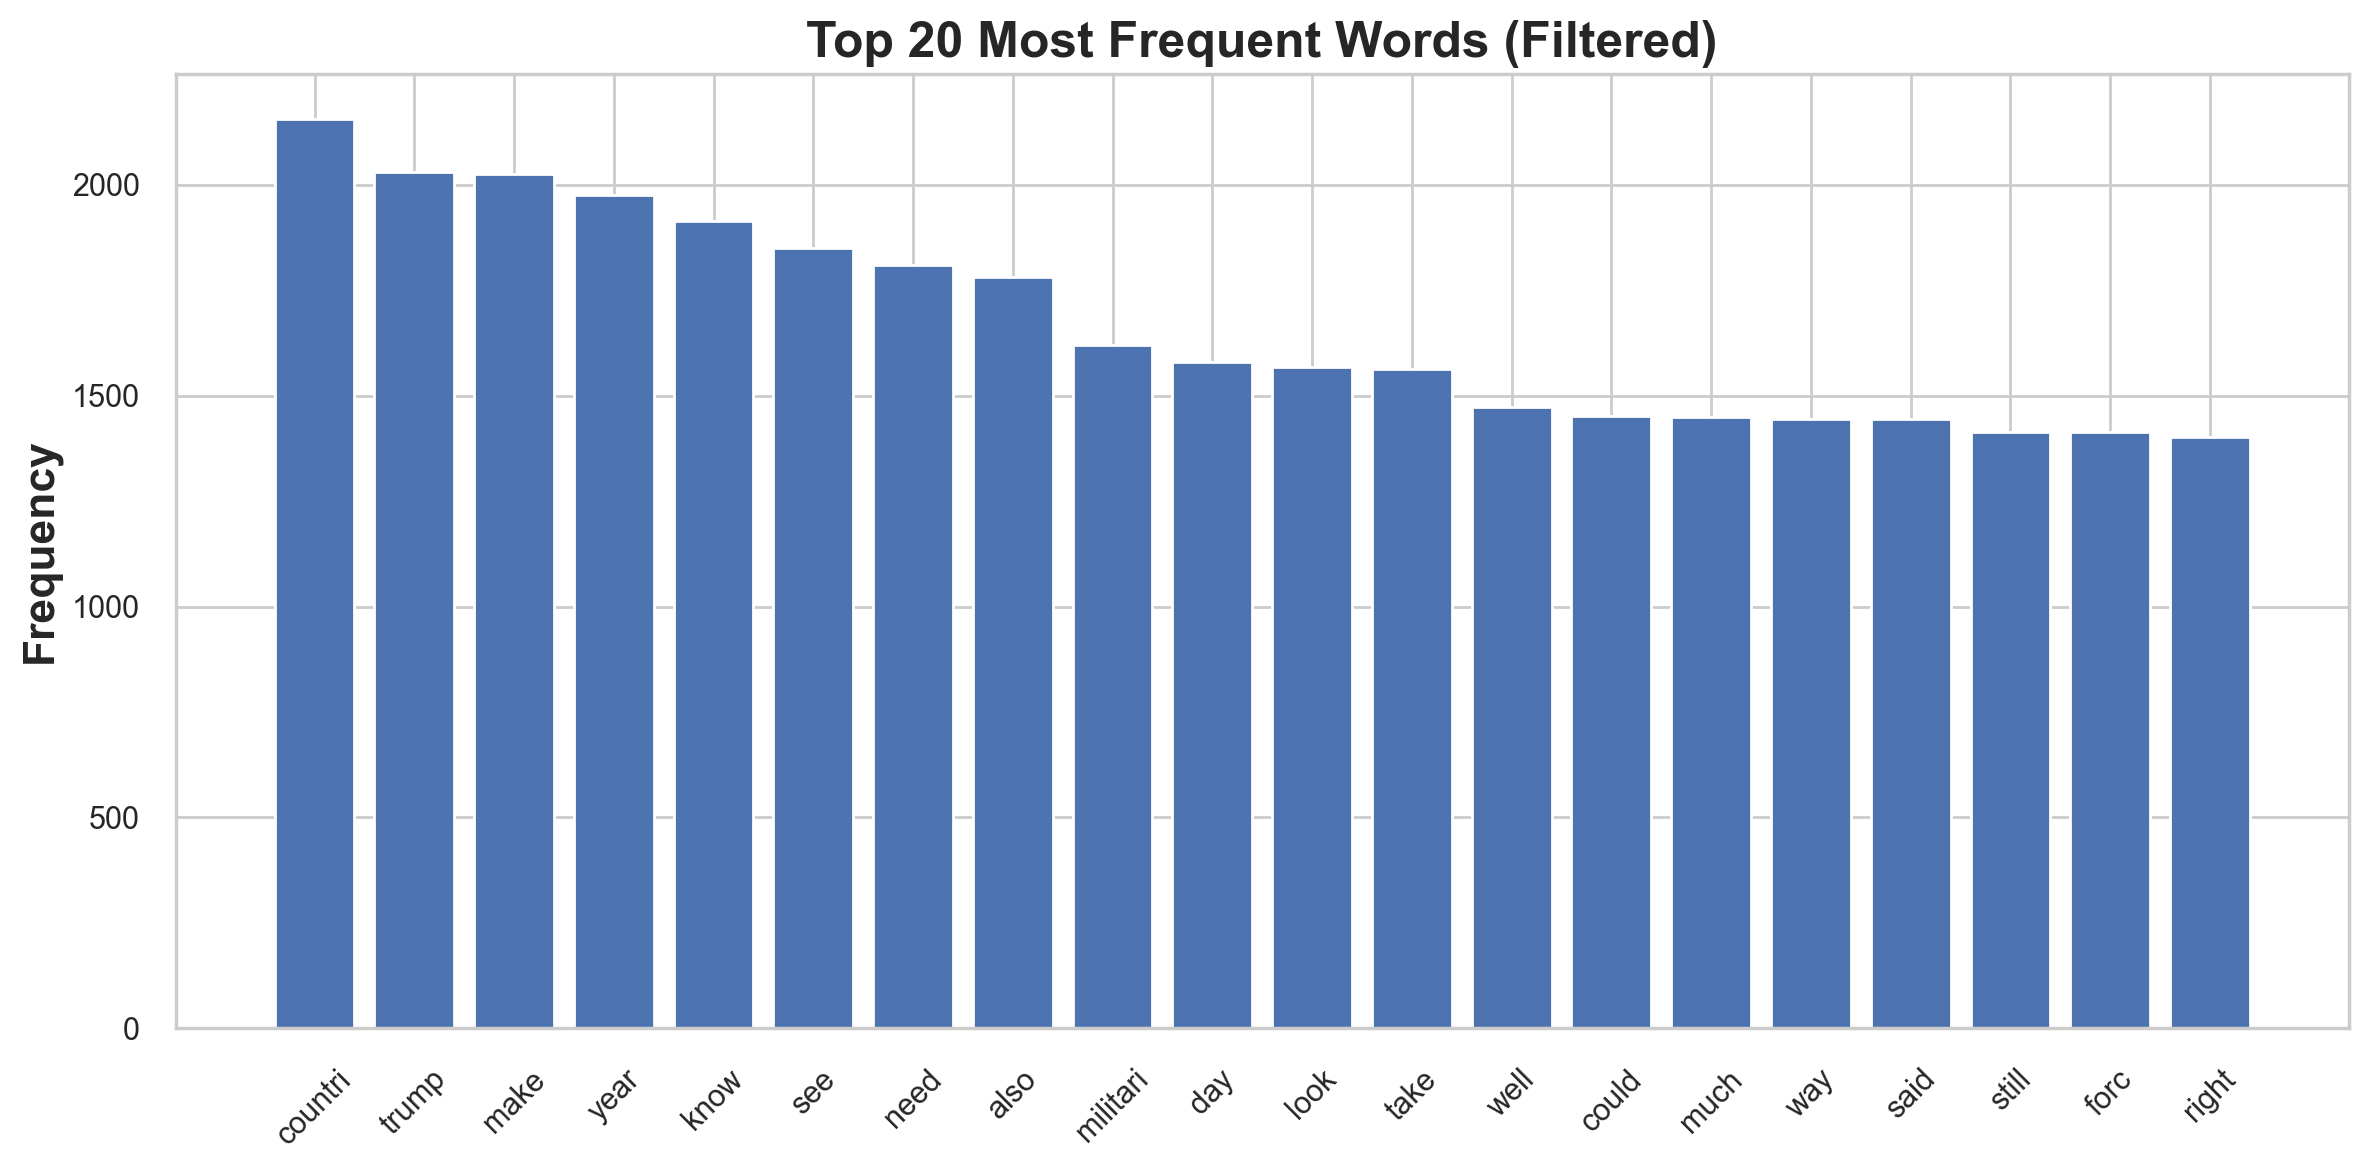

In [29]:
# Flatten all tokens
all_tokens = [token for sublist in df["final_tokens"] for token in sublist]
token_counts = Counter(all_tokens)
top_words = token_counts.most_common(20)

# Plot
words, counts = zip(*top_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words (Filtered)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

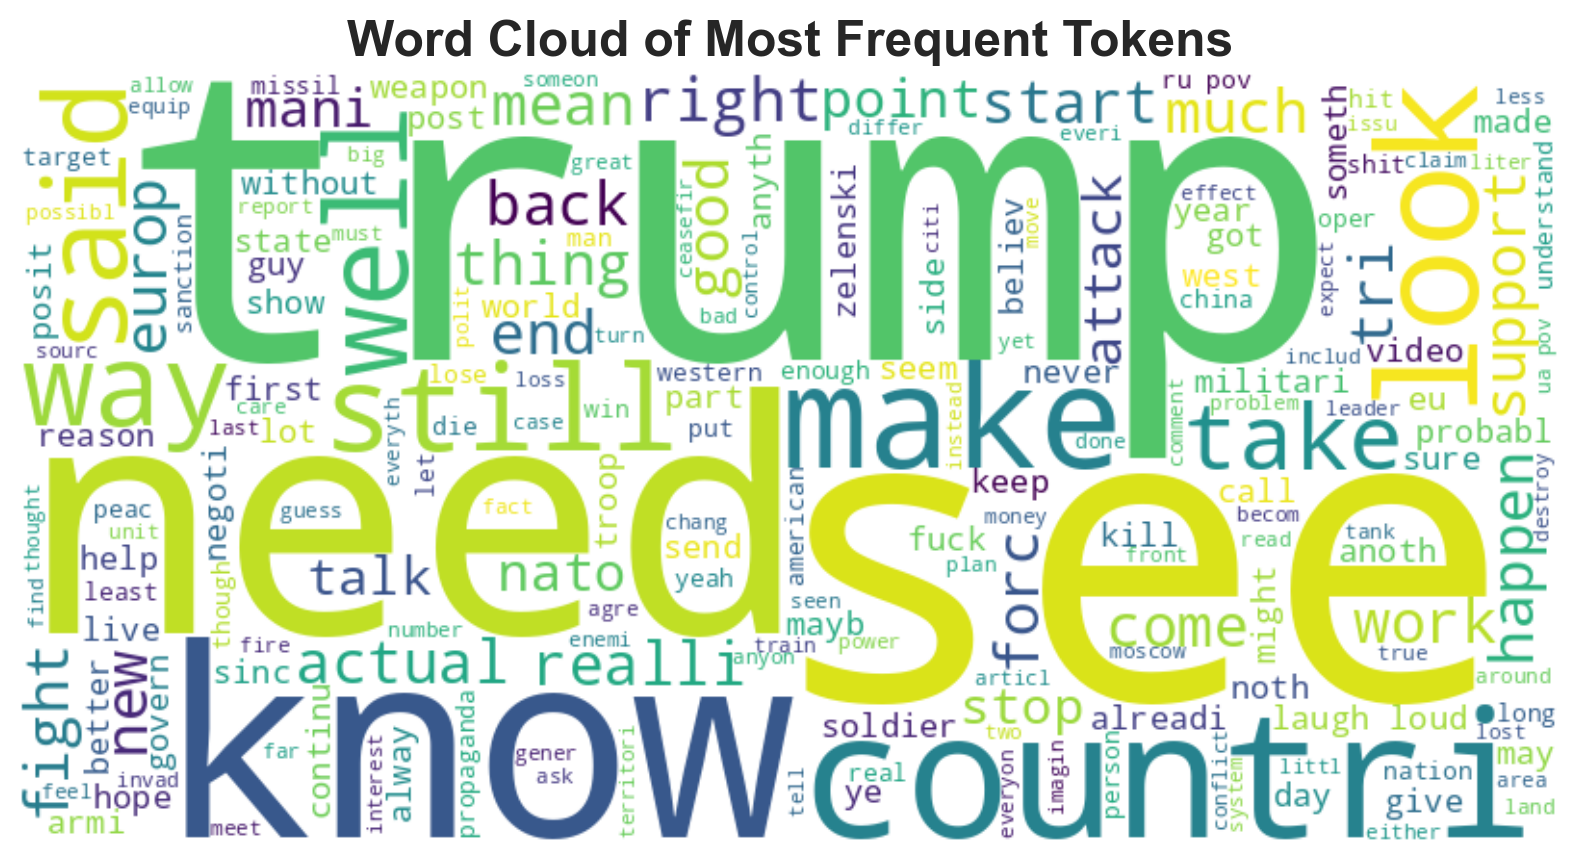

In [30]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Tokens")
plt.show()

In [31]:
nltk.download("vader_lexicon")

# Initialize VADER
sia = SentimentIntensityAnalyzer()
analyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/avriowork/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [32]:
# Apply VADER sentiment analysis
df["vader_scores"] = df["cleaned_string"].astype(str).apply(analyzer.polarity_scores)
df["compound"] = df["vader_scores"].apply(lambda x: x["compound"])

# Custom sentiment classification
def classify_custom_vader(score):
    if score >= 0.01:
        return "positive"
    elif score <= -0.01:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["compound"].apply(classify_custom_vader)

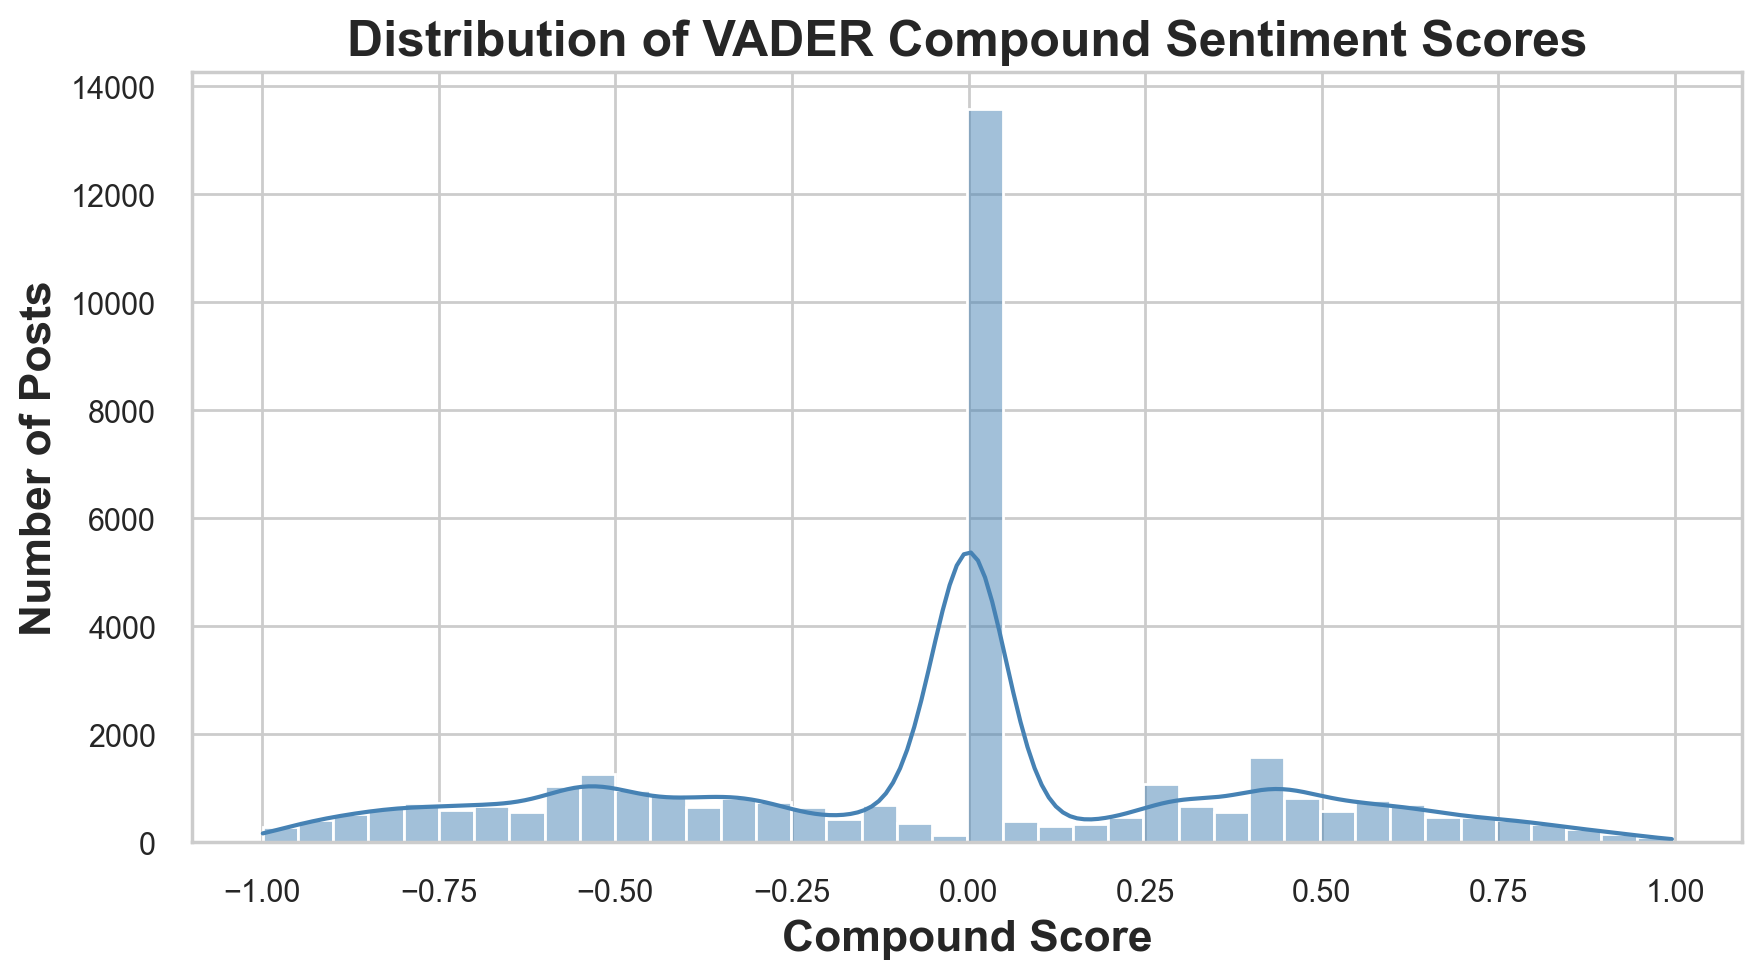

In [33]:
plt.figure(figsize=(10, 5))
sns.histplot(df["compound"], bins=40, kde=True, color="steelblue")
plt.title("Distribution of VADER Compound Sentiment Scores")
plt.xlabel("Compound Score")
plt.ylabel("Number of Posts")
plt.grid(True)
plt.show()

In [34]:
df.groupby("sentiment")["compound"].mean().sort_values(ascending=False)

sentiment
positive    4.540388e-01
neutral    -6.333409e-07
negative   -5.062962e-01
Name: compound, dtype: float64

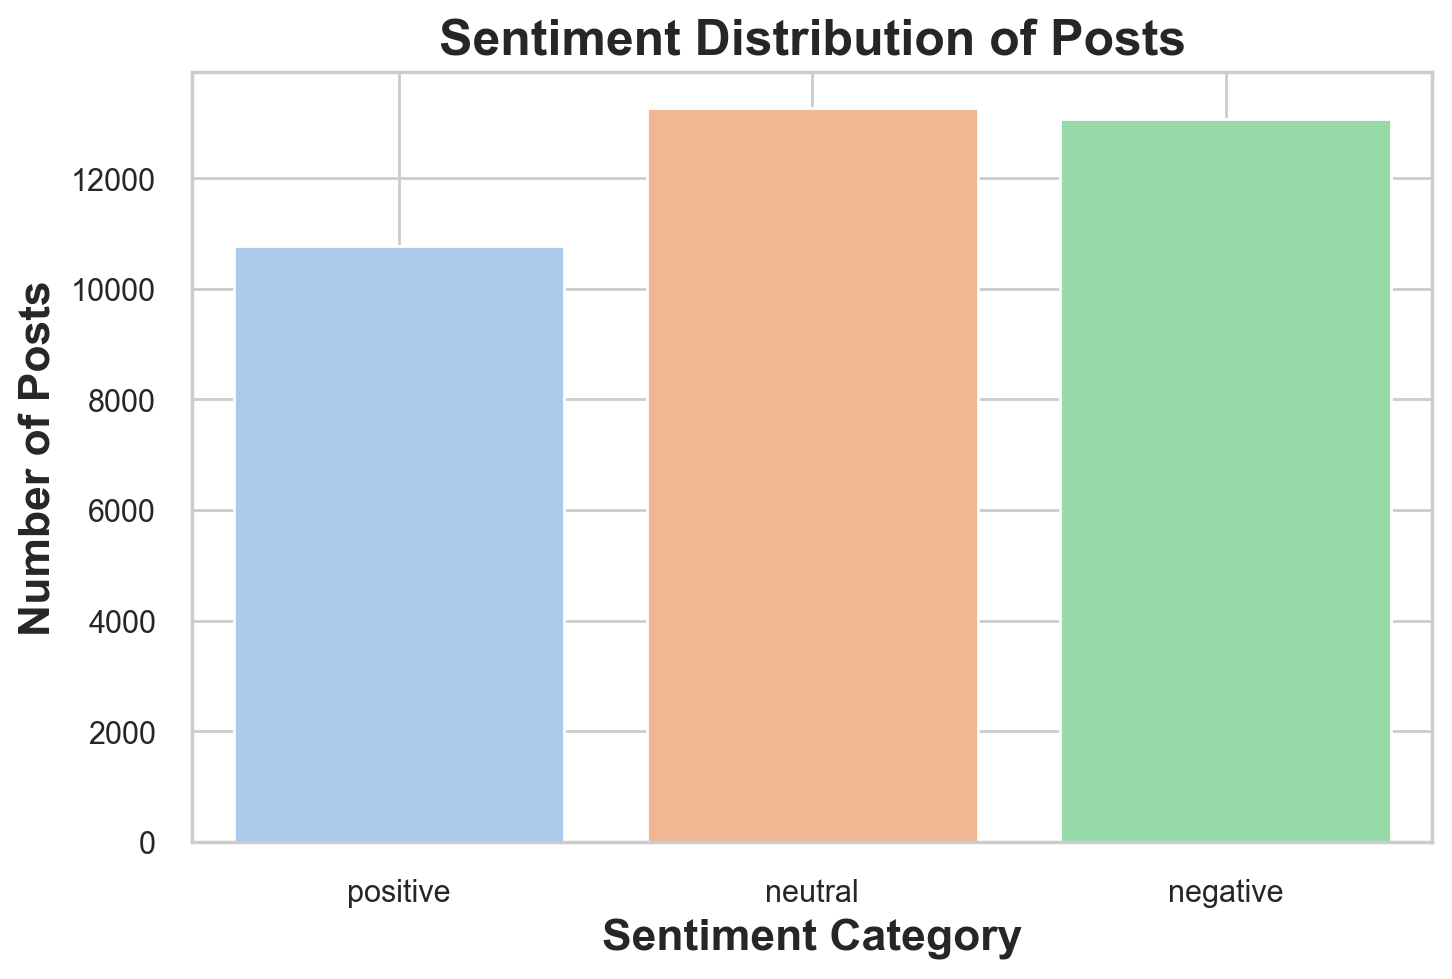

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="sentiment", palette="pastel", order=["positive", "neutral", "negative"])
plt.title("Sentiment Distribution of Posts")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Posts")
plt.grid(True)
plt.show()


In [36]:
# Vectorizer parameters
vectorizer_params = {
    'max_df': 0.9,
    'min_df': 5,
    'stop_words': 'english',
    'max_features': 1000
}

lda_params = {
    'n_components': 6,
    'random_state': 20
}

text_data = df["cleaned_string"]

In [37]:
cv_vectorizer = CountVectorizer(**vectorizer_params)
dtm_cv = cv_vectorizer.fit_transform(text_data)

lda_cv = LatentDirichletAllocation(**lda_params)
lda_cv.fit(dtm_cv)

LatentDirichletAllocation(n_components=6, random_state=20)

In [ ]:
def plot_topic_word_bars(lda_model, vectorizer, n_top_words=10, title_prefix="Topic"):
    feature_names = vectorizer.get_feature_names_out()
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_word_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        top_weights = topic[top_word_indices]

        # Construct title from top 5 words
        topic_label = ", ".join(top_words[:5])

        # Plot
        plt.figure(figsize=(10, 4))
        sns.barplot(x=top_weights, y=top_words, palette="viridis")
        plt.title(f"{title_prefix} {topic_idx + 1}: {topic_label}")
        plt.xlabel("Word Importance")
        plt.ylabel("Top Words")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
def plot_topics_from_week6(model, vectorizer, n_top_words=10):
    feature_names = vectorizer.get_feature_names_out()
    
    for topic_idx, topic in enumerate(model.components_):
        top_word_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        top_weights = topic[top_word_indices]

        # Combine top 5 words into label
        top_label = ", ".join(top_words[:5])

        # Plot
        plt.figure(figsize=(10, 4))
        sns.barplot(x=top_weights, y=top_words, palette="cubehelix")
        plt.title(f" Topic {topic_idx + 1}: {top_label}", fontsize=14)
        plt.xlabel("Importance (Word Weight)")
        plt.ylabel("Top Words")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [ ]:
# Enable inline display (optional)
pyLDAvis.enable_notebook()

# Create interactive panel
panel = pyLDAvis.lda_model.prepare(lda_cv, dtm_cv, cv_vectorizer, mds='tsne')
pyLDAvis.display(panel)

In [67]:
feature_names = cv_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_cv.components_):
    top_indices = topic.argsort()[:-6:-1]         # top 5 words
    top_words = [feature_names[i] for i in top_indices]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

Topic 1: laugh, know, trump, loud, realli
Topic 2: good, guy, know, sure, look
Topic 3: countri, nato, weapon, missil, militari
Topic 4: peac, talk, trump, said, zelenski
Topic 5: pov, ru, ua, sanction, oil
Topic 6: year, forc, troop, attack, militari


In [41]:
print("CountVectorizer Model Perplexity:", lda_cv.perplexity(dtm_cv))

CountVectorizer Model Perplexity: 780.6043600397039


In [42]:
print("CountVectorizer Model Log Likelihood:", lda_cv.score(dtm_cv))

CountVectorizer Model Log Likelihood: -2104921.290602775


In [ ]:
# ---- Stage 4: Graph Construction & SNA ----

# Map each post/comment ID → author
id2author = dict(zip(df['id'], df['author']))

In [ ]:
# Build directed graph
G = nx.DiGraph()
G.add_nodes_from(df['author'].unique())

In [ ]:
# Add “reply” edges (commenter → parent_author)
for _, row in df[df['type']=='comment'].iterrows():
    child = row['author']
    # parent_id is like "t3_XXXXX" or "t1_YYYYY"
    parent = id2author.get(row['parent_id'].split('_')[-1])
    if parent:
        G.add_edge(child, parent, type='reply')

In [ ]:
# (Optional) Add “mention” edges (author → u/username)
mention_pattern = re.compile(r'u/([A-Za-z0-9_-]+)')
for _, row in df.iterrows():
    author = row['author']
    for m in mention_pattern.findall(row['text'] or ""):
        G.add_edge(author, m, type='mention')

In [ ]:
# Compute centrality measures
deg_cent = nx.degree_centrality(G)
bet_cent = nx.betweenness_centrality(G)
eig_cent = nx.eigenvector_centrality(G, max_iter=1000)

In [ ]:
# Assemble into a DataFrame
centrality_df = pd.DataFrame({
    'degree': deg_cent,
    'betweenness': bet_cent,
    'eigenvector': eig_cent
})

In [45]:
# Get top-5 by degree and display as Markdown
top5 = (
    centrality_df
    .sort_values('degree', ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'index':'user'})
)

display(Markdown(top5.to_markdown(index=False)))


| user               |    degree |   betweenness |   eigenvector |
|:-------------------|----------:|--------------:|--------------:|
| FruitSila          | 0.0746757 |    0.0220012  |    0.35348    |
| None               | 0.0728224 |    0.154564   |    0.0324539  |
| dailystar_news     | 0.06977   |    0.0166378  |    0.00590533 |
| Swimming-Beyond378 | 0.0601766 |    0.0344713  |    0.00768705 |
| Ripamon            | 0.0594135 |    0.017023   |    0.286287   |
| SmokeSinseLoud     | 0.0570152 |    0          |    0.00672616 |
| TheExpressUS       | 0.0551619 |    0          |    0.00644781 |
| Flimsy_Pudding1362 | 0.0539627 |    0.0152818  |    0.304875   |
| Prior-Case58       | 0.0480759 |    0          |    0.00489725 |
| ArchitectMary      | 0.0436062 |    0.00212167 |    0.236226   |

In [46]:
# ---- Stage 4b: Summary Statistics & Further SNA ----

# Compute raw degrees + all centralities
in_deg       = dict(G.in_degree())
out_deg      = dict(G.out_degree())
deg_cent     = nx.degree_centrality(G)
eig_cent     = nx.eigenvector_centrality(G, max_iter=1000)
katz_cent    = nx.katz_centrality_numpy(G, alpha=0.005)           # tweak alpha if needed
close_cent   = nx.closeness_centrality(G)
bet_cent     = nx.betweenness_centrality(G)

In [47]:
# Assemble into DataFrame
metrics_df = pd.DataFrame({
    'in_degree'      : pd.Series(in_deg),
    'out_degree'     : pd.Series(out_deg),
    'deg_cent'       : pd.Series(deg_cent),
    'eig_cent'       : pd.Series(eig_cent),
    'katz_cent'      : pd.Series(katz_cent),
    'close_cent'     : pd.Series(close_cent),
    'betw_cent'      : pd.Series(bet_cent),
})

In [52]:
# Summary statistics
# Get the raw summary (metrics = columns, stats = rows)
raw_summary = metrics_df.describe()

# Rename stats (index) to full names
raw_summary.index = [
    "Count", "Mean", "Std. Dev", "Min",
    "25th Percentile", "50th Percentile",
    "75th Percentile", "Max"
]

# Rename metrics (columns) to full headings
raw_summary = raw_summary.rename(columns={
    'in_degree'  : 'In-Degree',
    'out_degree' : 'Out-Degree',
    'deg_cent'   : 'Degree Centrality',
    'eig_cent'   : 'Eigenvector Centrality',
    'katz_cent'  : 'Katz Centrality',
    'close_cent' : 'Closeness Centrality',
    'betw_cent'  : 'Betweenness Centrality',
})

# Transpose so metrics are rows, stats are columns
pretty_summary = raw_summary

# Style it
styled = (
    pretty_summary
    .style
    .format({
        'Count'            : '{:.0f}',
        'Mean'             : '{:.4f}',
        'Std. Dev'         : '{:.4f}',
        'Min'              : '{:.0f}',
        '25th Percentile'  : '{:.0f}',
        '50th Percentile'  : '{:.0f}',
        '75th Percentile'  : '{:.0f}',
        'Max'              : '{:.0f}'
    })
    .set_caption("Reply Chain Graph — Summary Statistics — Centrality Measures")
    .set_table_styles([
        {'selector': 'caption',
         'props': [
             ('caption-side', 'top'),
             ('font-size', '1.1em'),
             ('font-weight', 'bold'),
             ('text-align','center')
         ]},
        {'selector': 'th',
         'props': [('background-color', '#4C72B0'),
                   ('color', 'white'),
                   ('font-weight','bold')]},
        {'selector': 'td',
         'props': [('padding', '4px 8px')]}
    ])
)

display(styled)

,In-Degree,Out-Degree,Degree Centrality,Eigenvector Centrality,Katz Centrality,Closeness Centrality,Betweenness Centrality
Count,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000
Mean,3.150425,3.150425,0.000687,0.001598,0.010381,0.054853,0.000120
Std. Dev,20.545553,7.402805,0.002635,0.010318,0.001114,0.071782,0.001837
Min,0.000000,0.000000,0.000000,0.000000,0.010202,0.000000,0.000000
25th Percentile,0.000000,1.000000,0.000109,0.000000,0.010202,0.000000,0.000000
50th Percentile,0.000000,1.000000,0.000218,0.000000,0.010202,0.000000,0.000000
75th Percentile,2.000000,3.000000,0.000545,0.000054,0.010305,0.134927,0.000004
Max,638.000000,376.000000,0.074676,0.353480,0.044548,0.245387,0.154564


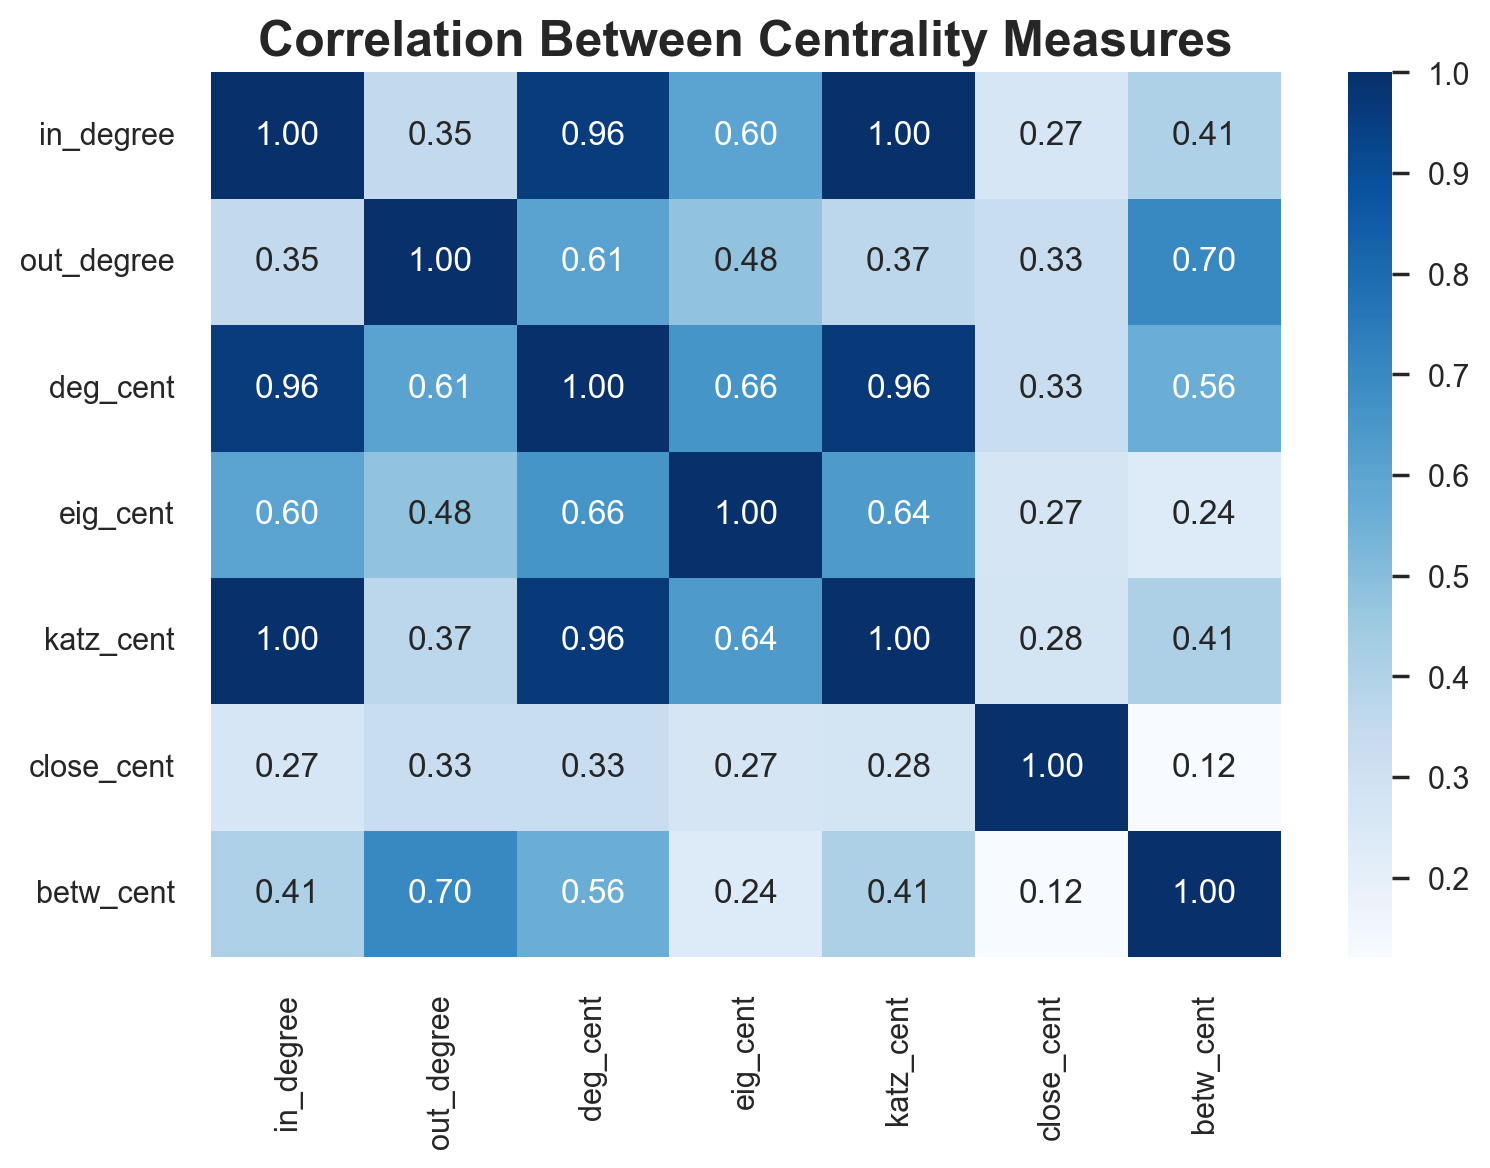

In [49]:
# Correlation heatmap
plt.figure(figsize=(8,6))
corr = metrics_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues")
plt.title("Correlation Between Centrality Measures")
plt.tight_layout()
plt.show()

In [53]:
# Some global network stats

print(f"Network density:           {nx.density(G):.4f}")
# average_clustering will implicitly treat it as undirected
print(f"Average clustering coeff:  {nx.average_clustering(G):.4f}")

# Build the undirected graph and find its largest connected component
UG = G.to_undirected()  
largest_cc = max(nx.connected_components(UG), key=len)

# Create an undirected subgraph on that component
H = UG.subgraph(largest_cc)

# Now diameter is well-defined on this undirected, connected subgraph
print(f"Diameter (largest comp):   {nx.diameter(H):d}")

Network density:           0.0003
Average clustering coeff:  0.0513
Diameter (largest comp):   9


### Engagement Metrics Correlation

Here we look at how **score**, **num_comments**, **upvote_ratio** and **compound sentiment** relate to one another.


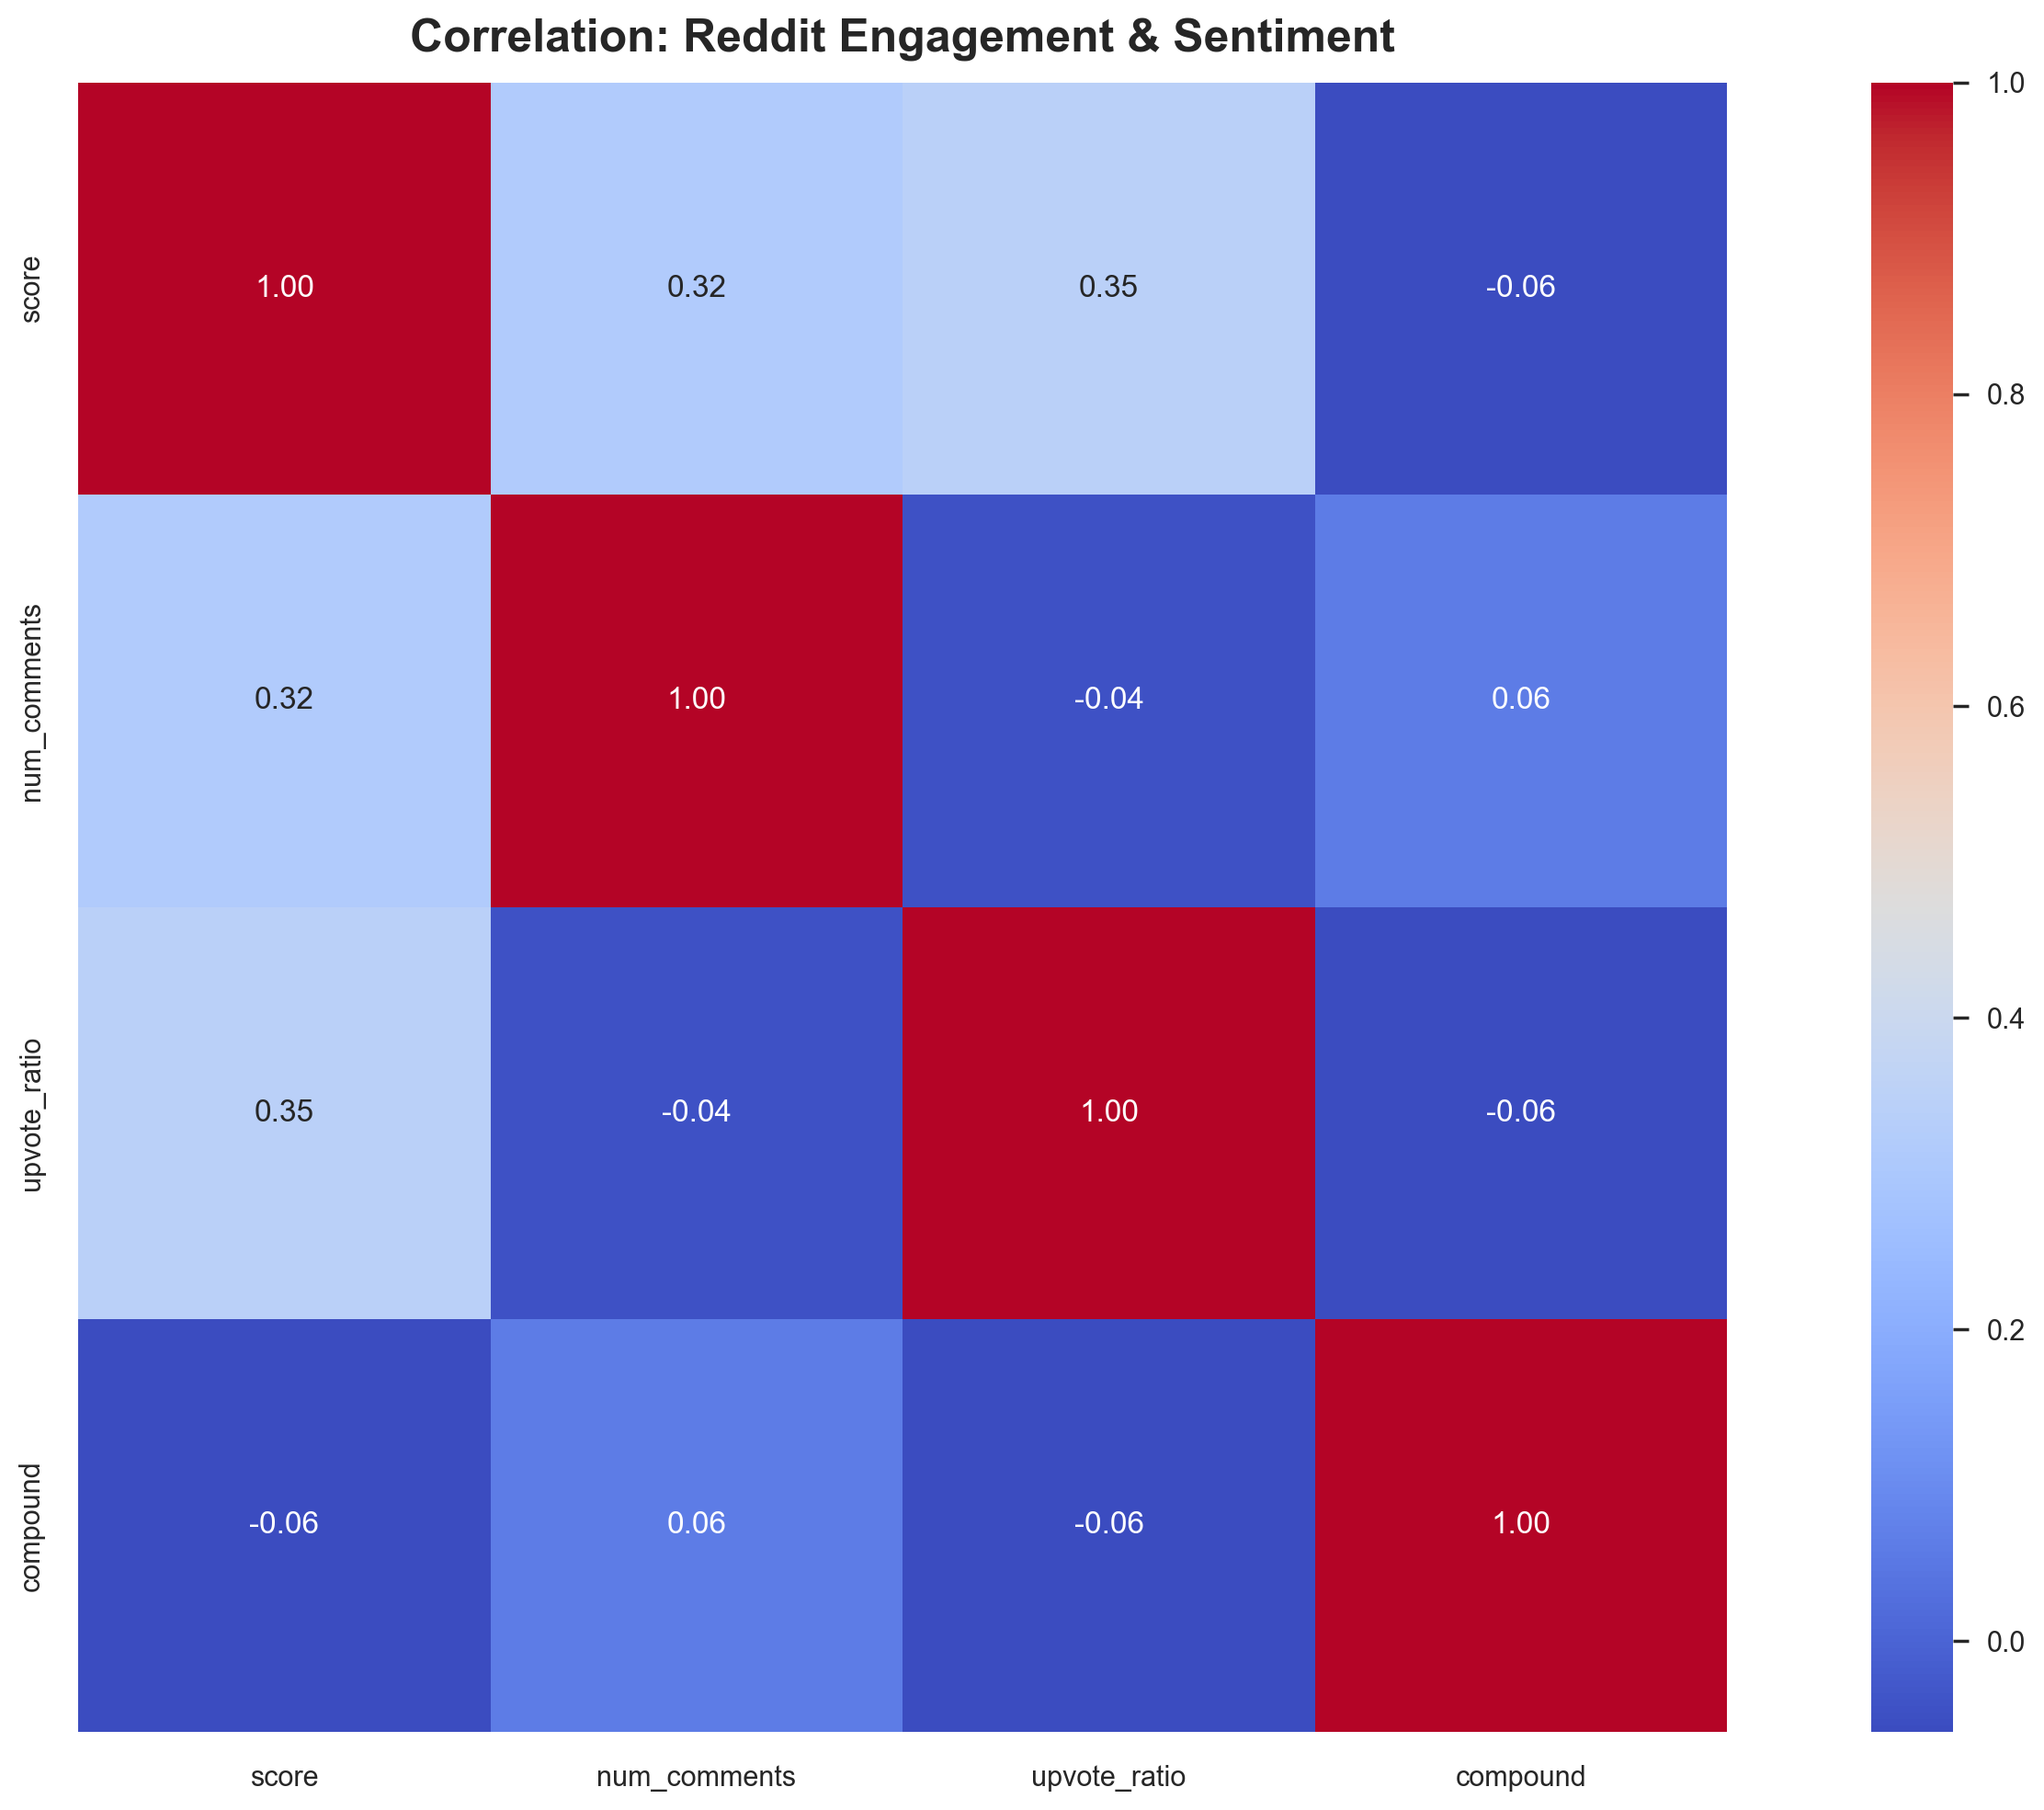

In [62]:
# assume you've already done: import seaborn as sns, matplotlib.pyplot as plt
# 1. Pick your columns
corr_df = df[['score', 'num_comments', 'upvote_ratio', 'compound']].copy()

# 2. Compute correlation
corr = corr_df.corr()

# 3. Plot heatmap
# plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation: Reddit Engagement & Sentiment", pad=12)
plt.tight_layout()
plt.show()

### Score vs. Comments Scatter

Each point is a post or comment; size by upvote_ratio, color by sentiment category.


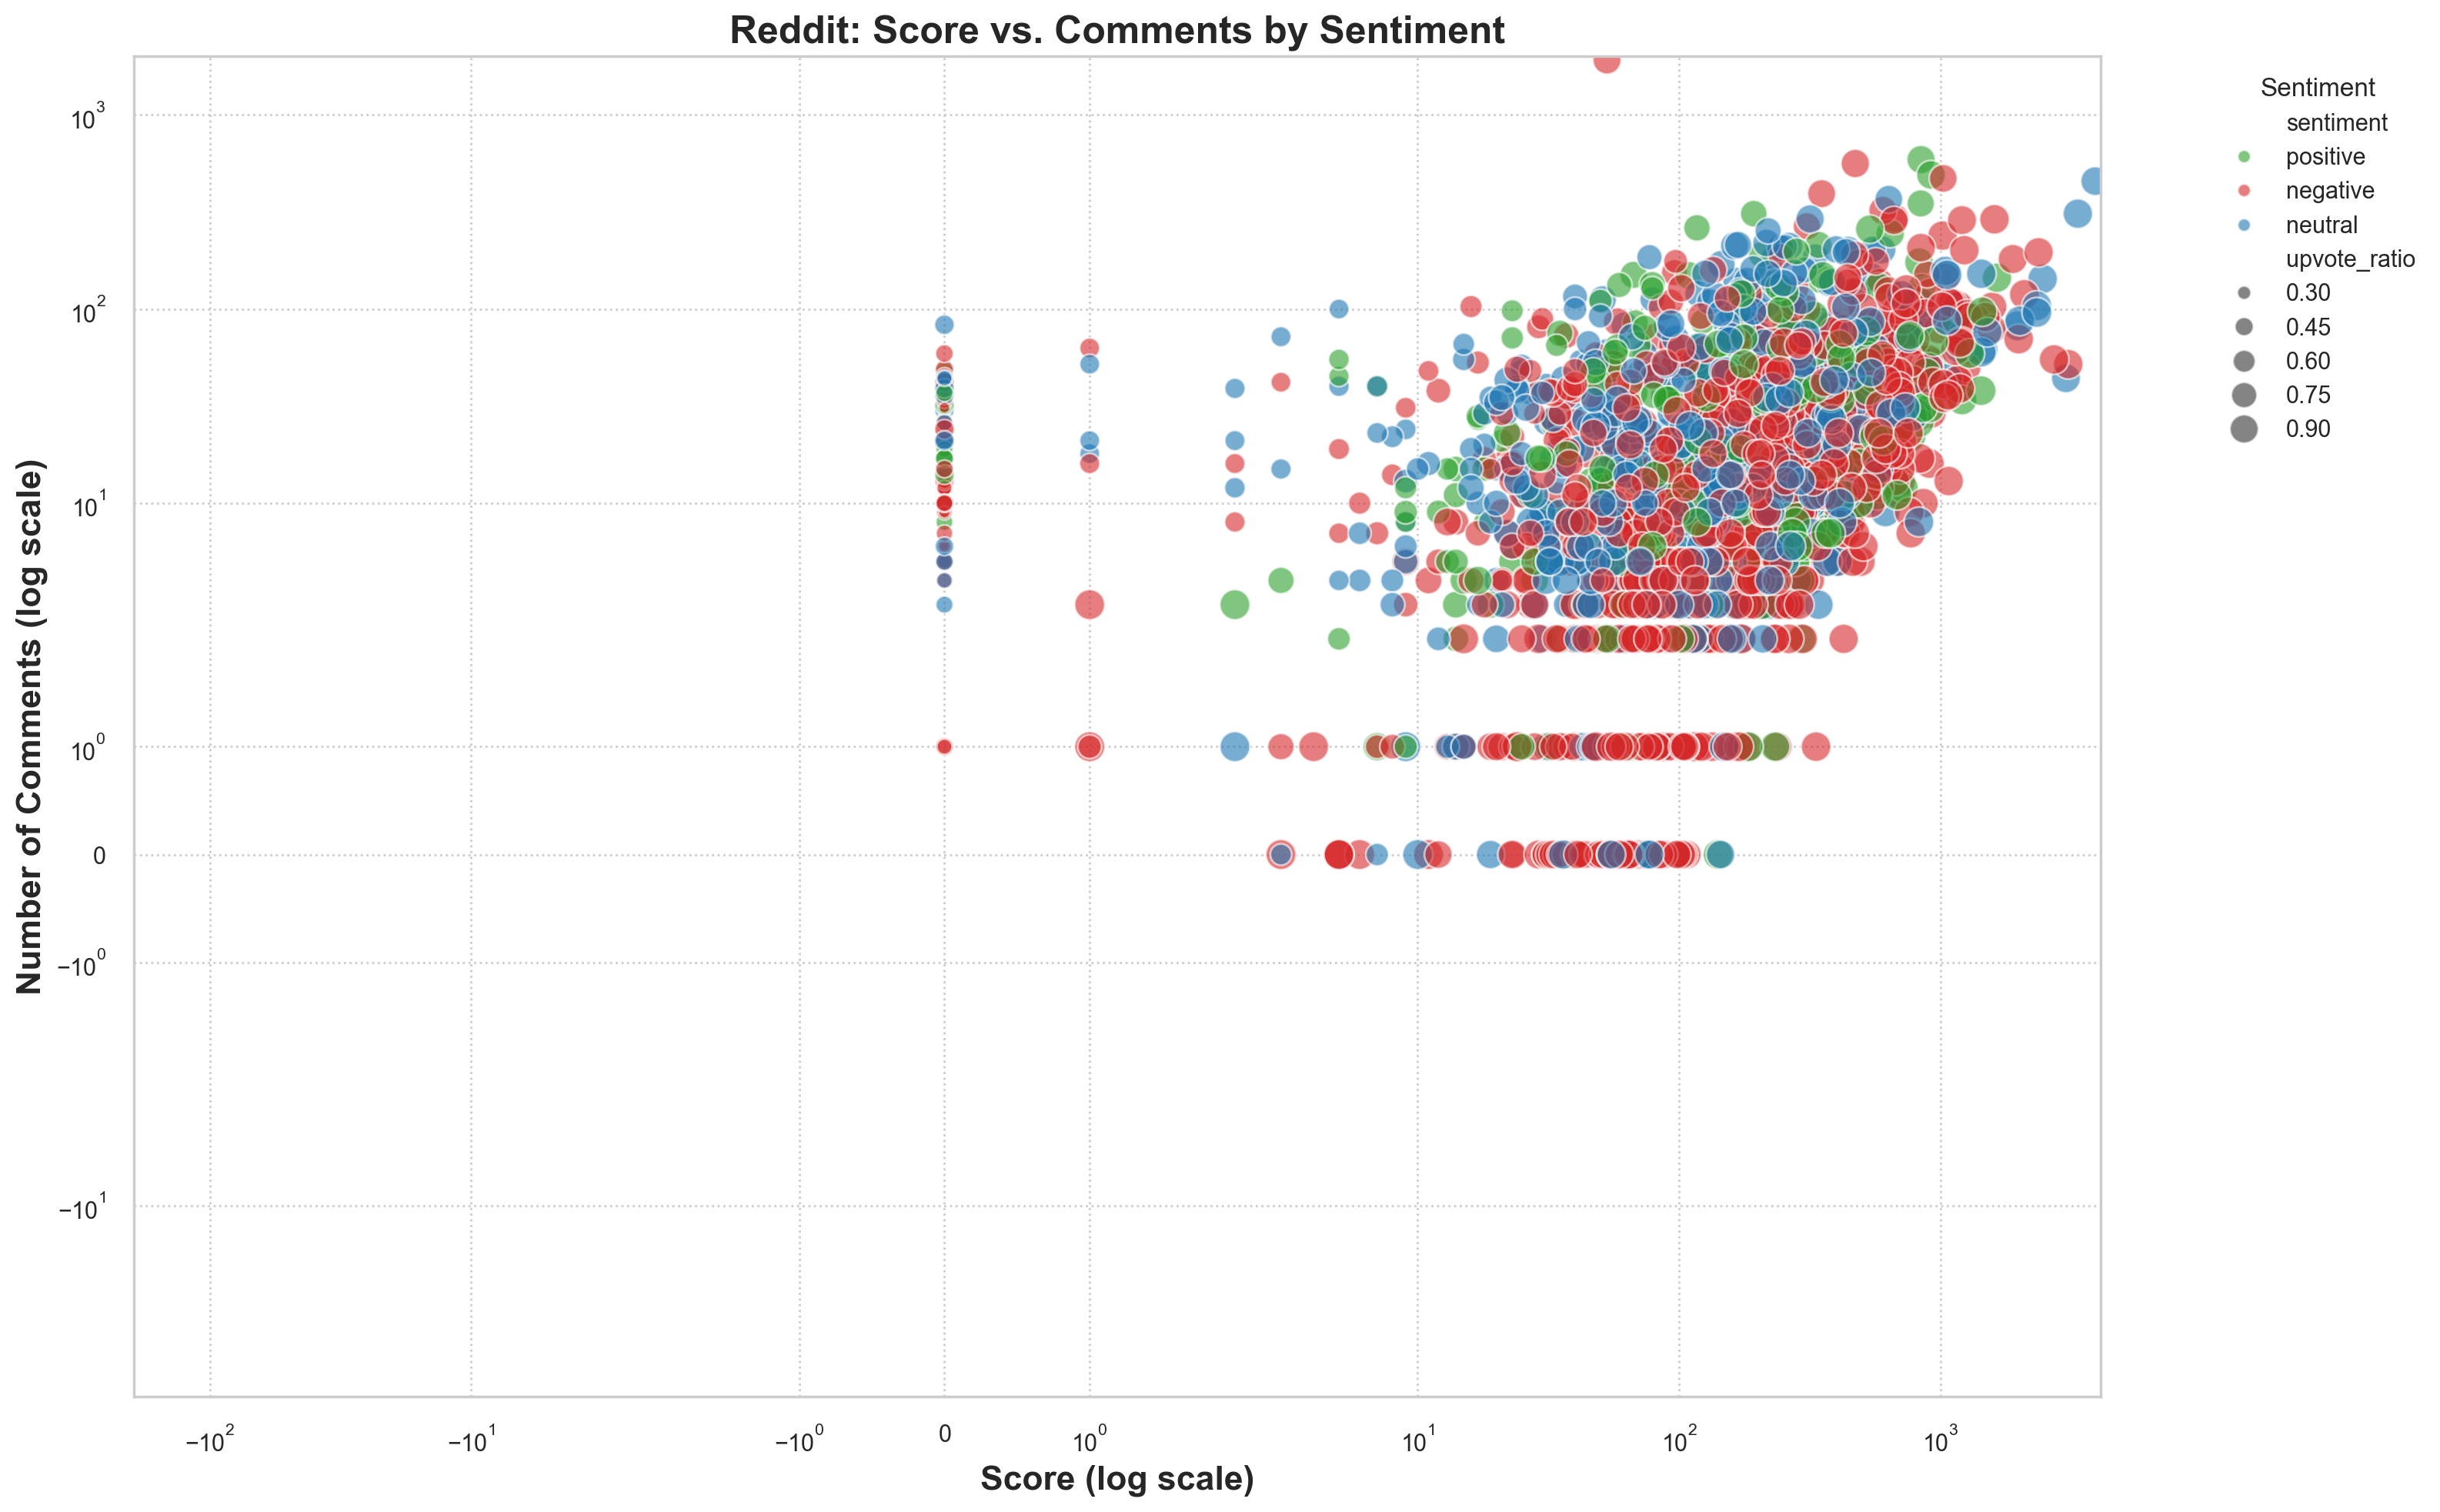

In [61]:
# prepare
palette = {'positive':'#2ca02c','neutral':'#1f77b4','negative':'#d62728'}
# plt.figure(figsize=(8,6))

# scatter
sns.scatterplot(
    data=df,
    x='score', y='num_comments',
    size='upvote_ratio', sizes=(20,200),
    hue='sentiment', palette=palette,
    alpha=0.6, edgecolor='w'
)

plt.xscale('symlog')   # handle zeros
plt.yscale('symlog')
plt.xlabel("Score (log scale)")
plt.ylabel("Number of Comments (log scale)")
plt.title("Reddit: Score vs. Comments by Sentiment")
plt.legend(bbox_to_anchor=(1.05,1), title="Sentiment")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


### Top 10 Highest-Scoring Posts

Bar chart of the top 10 submissions (by `score`).


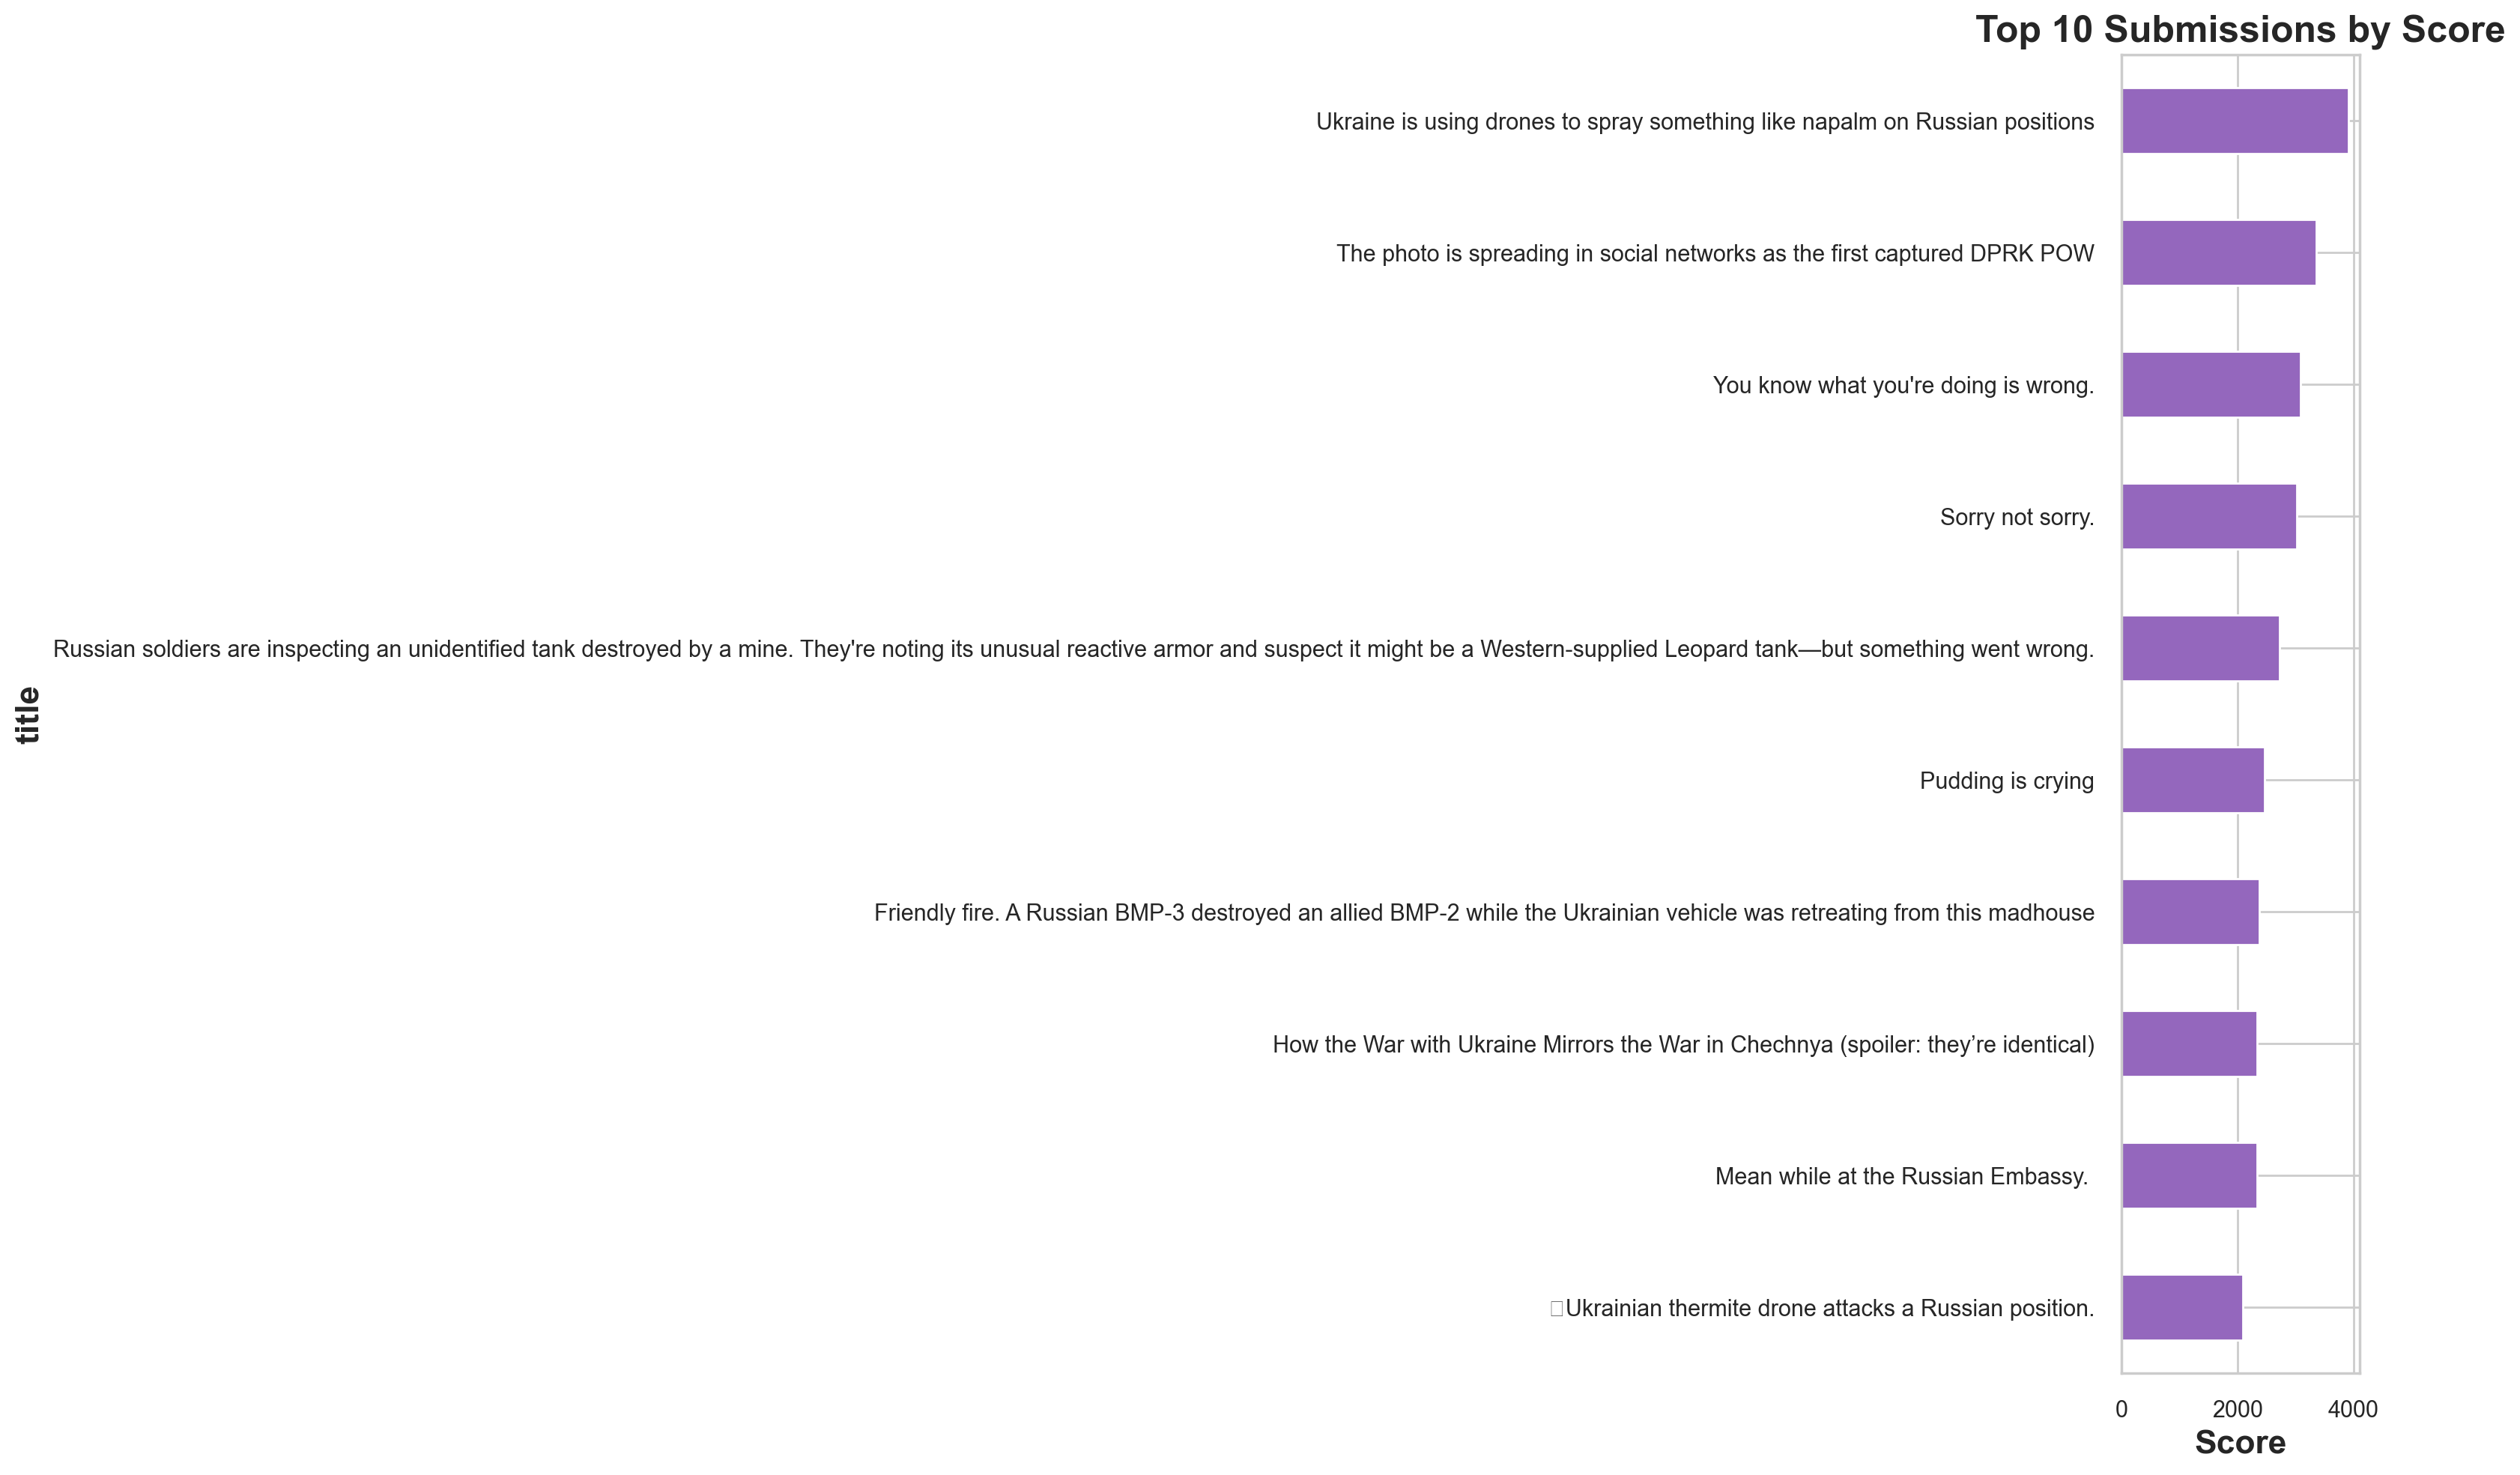

In [60]:
# filter only submissions
subs = df[df['type']=='submission']

# top 10
top10 = subs.nlargest(10, 'score')[['title','score']].set_index('title')

# plot
# plt.figure(figsize=(8,5))
top10['score'].sort_values().plot.barh(color='#9467bd')
plt.xlabel("Score")
plt.title("Top 10 Submissions by Score")
plt.tight_layout()
plt.show()


### Daily Submission & Comment Volume

How many posts/comments per day?


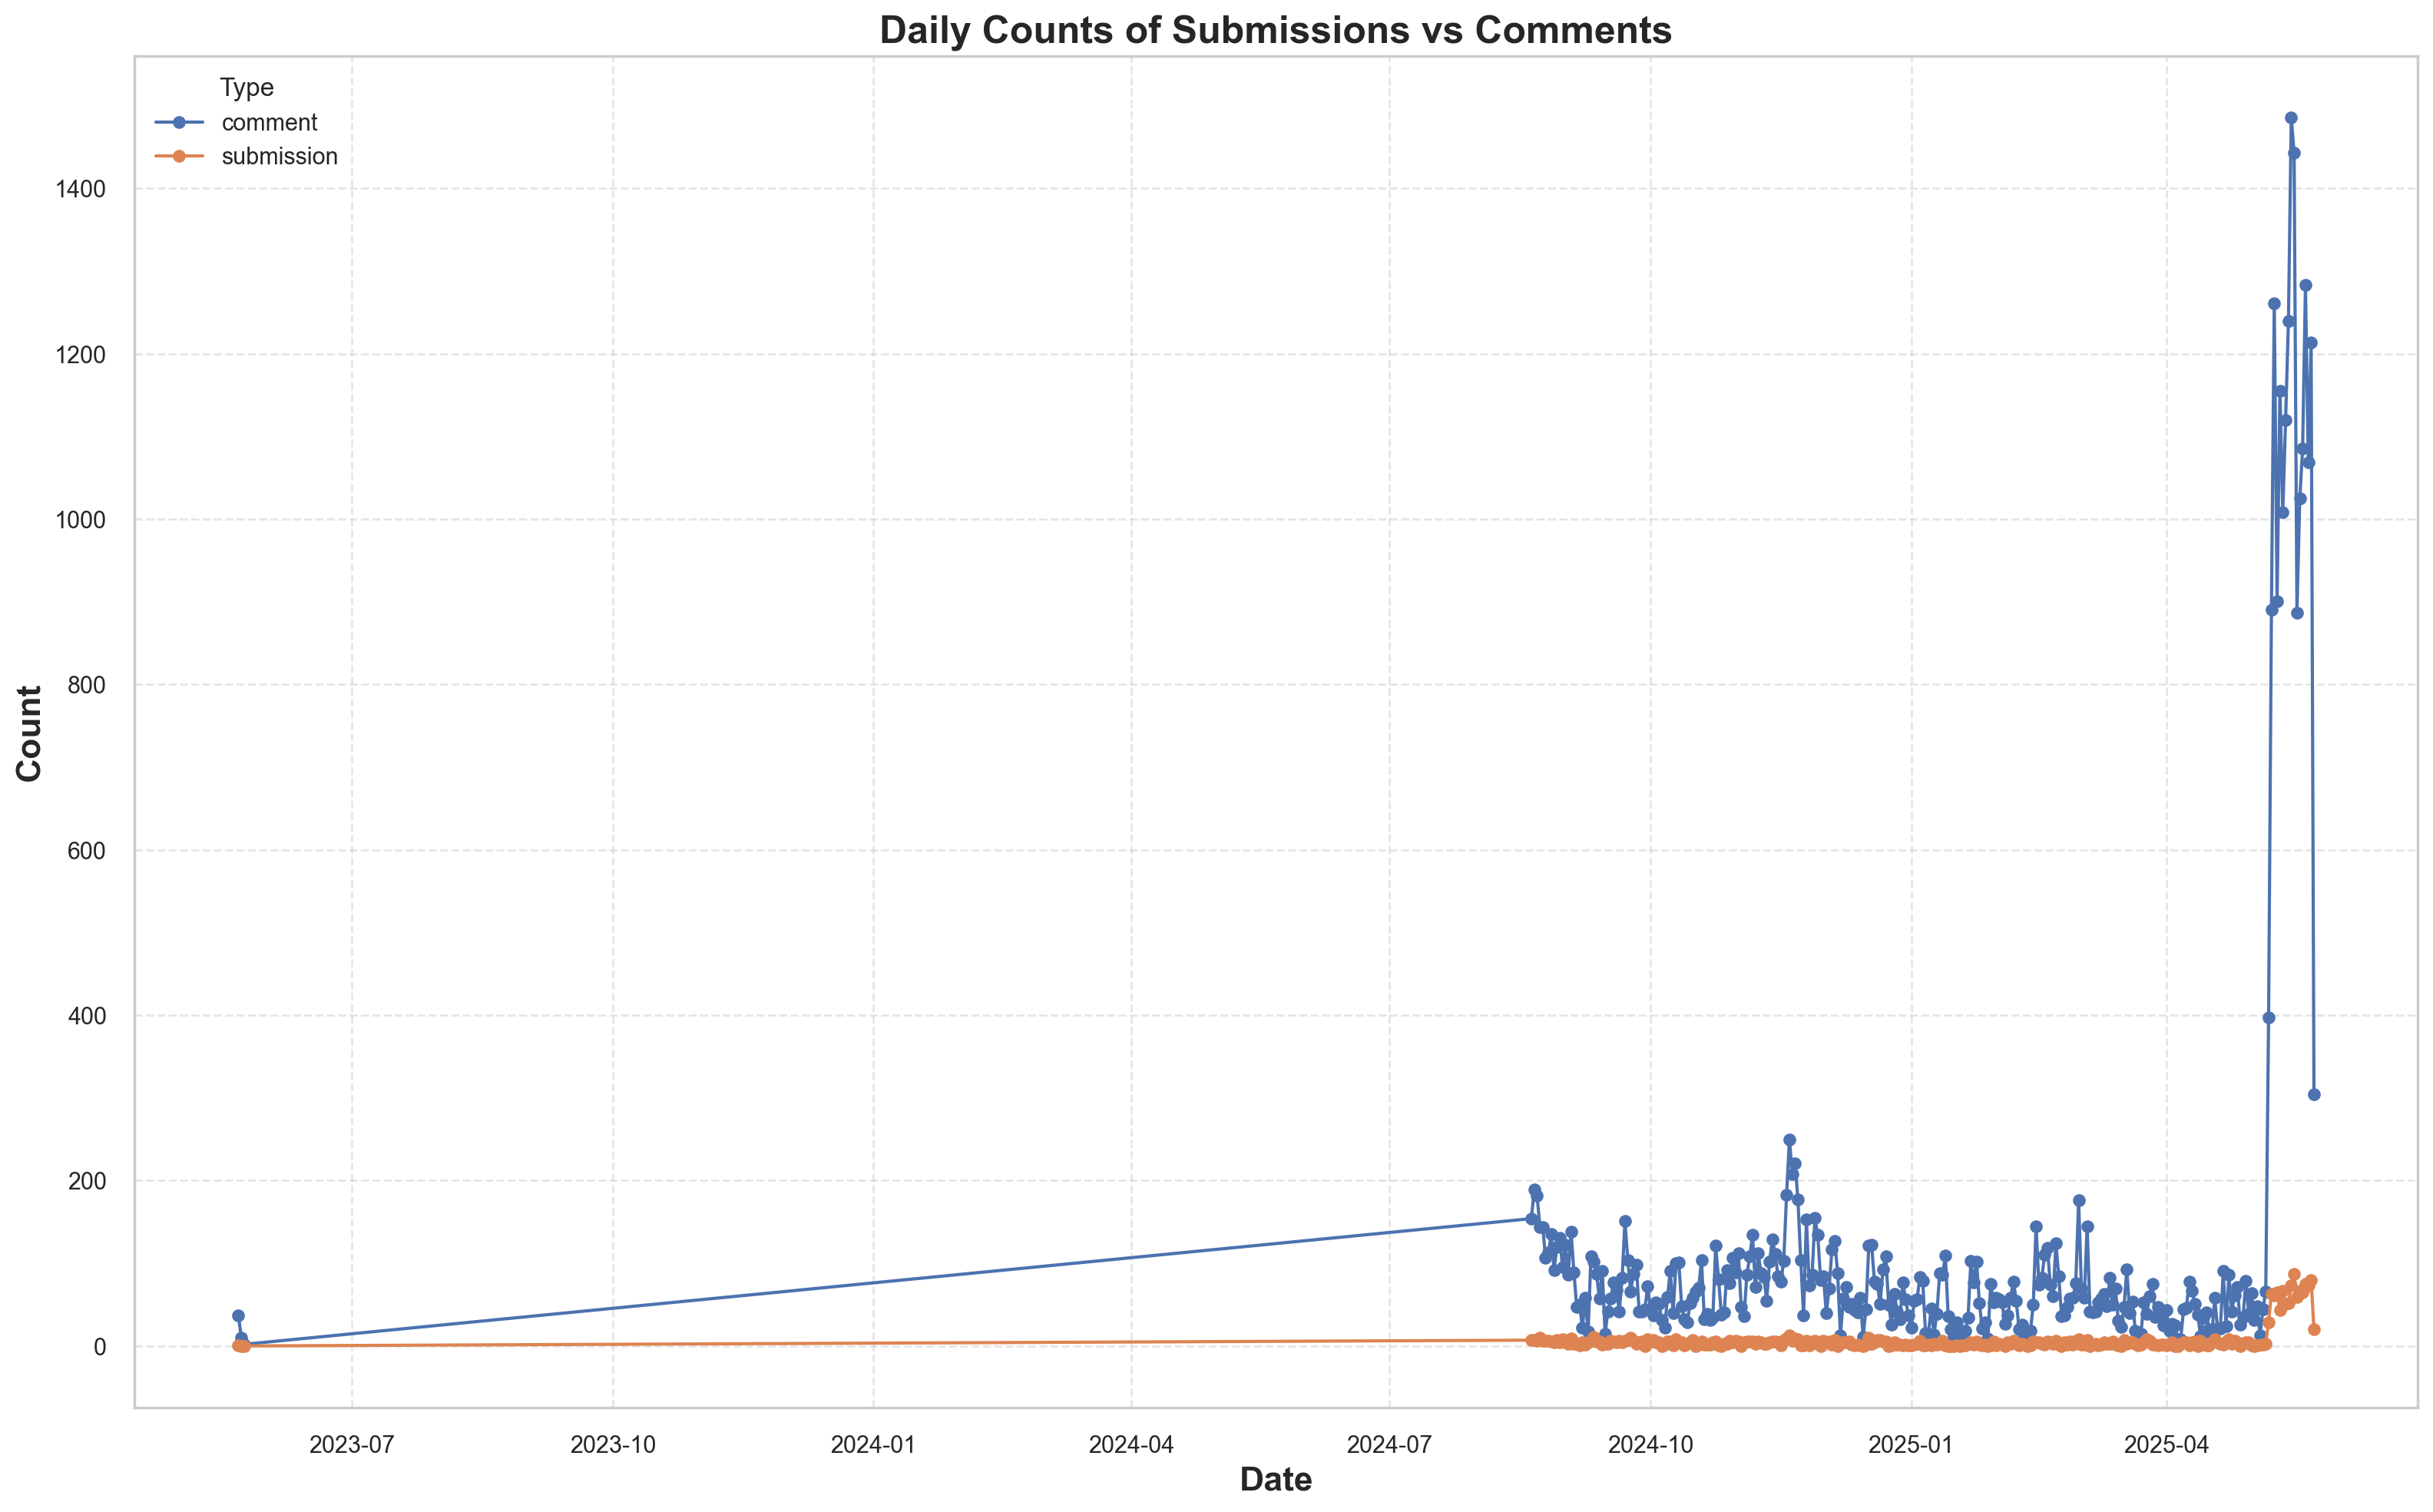

In [63]:
# convert created → datetime
df['date'] = pd.to_datetime(df['created']).dt.date

# daily counts
daily = df.groupby(['date','type']).size().unstack(fill_value=0)

# plot
daily.plot(
    kind='line',
    # figsize=(10,4),
    marker='o'
)
plt.title("Daily Counts of Submissions vs Comments")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(title="Type")
plt.grid(ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


### Posting Heatmap by Hour & Weekday

Shows which hours on which weekdays see the most activity.


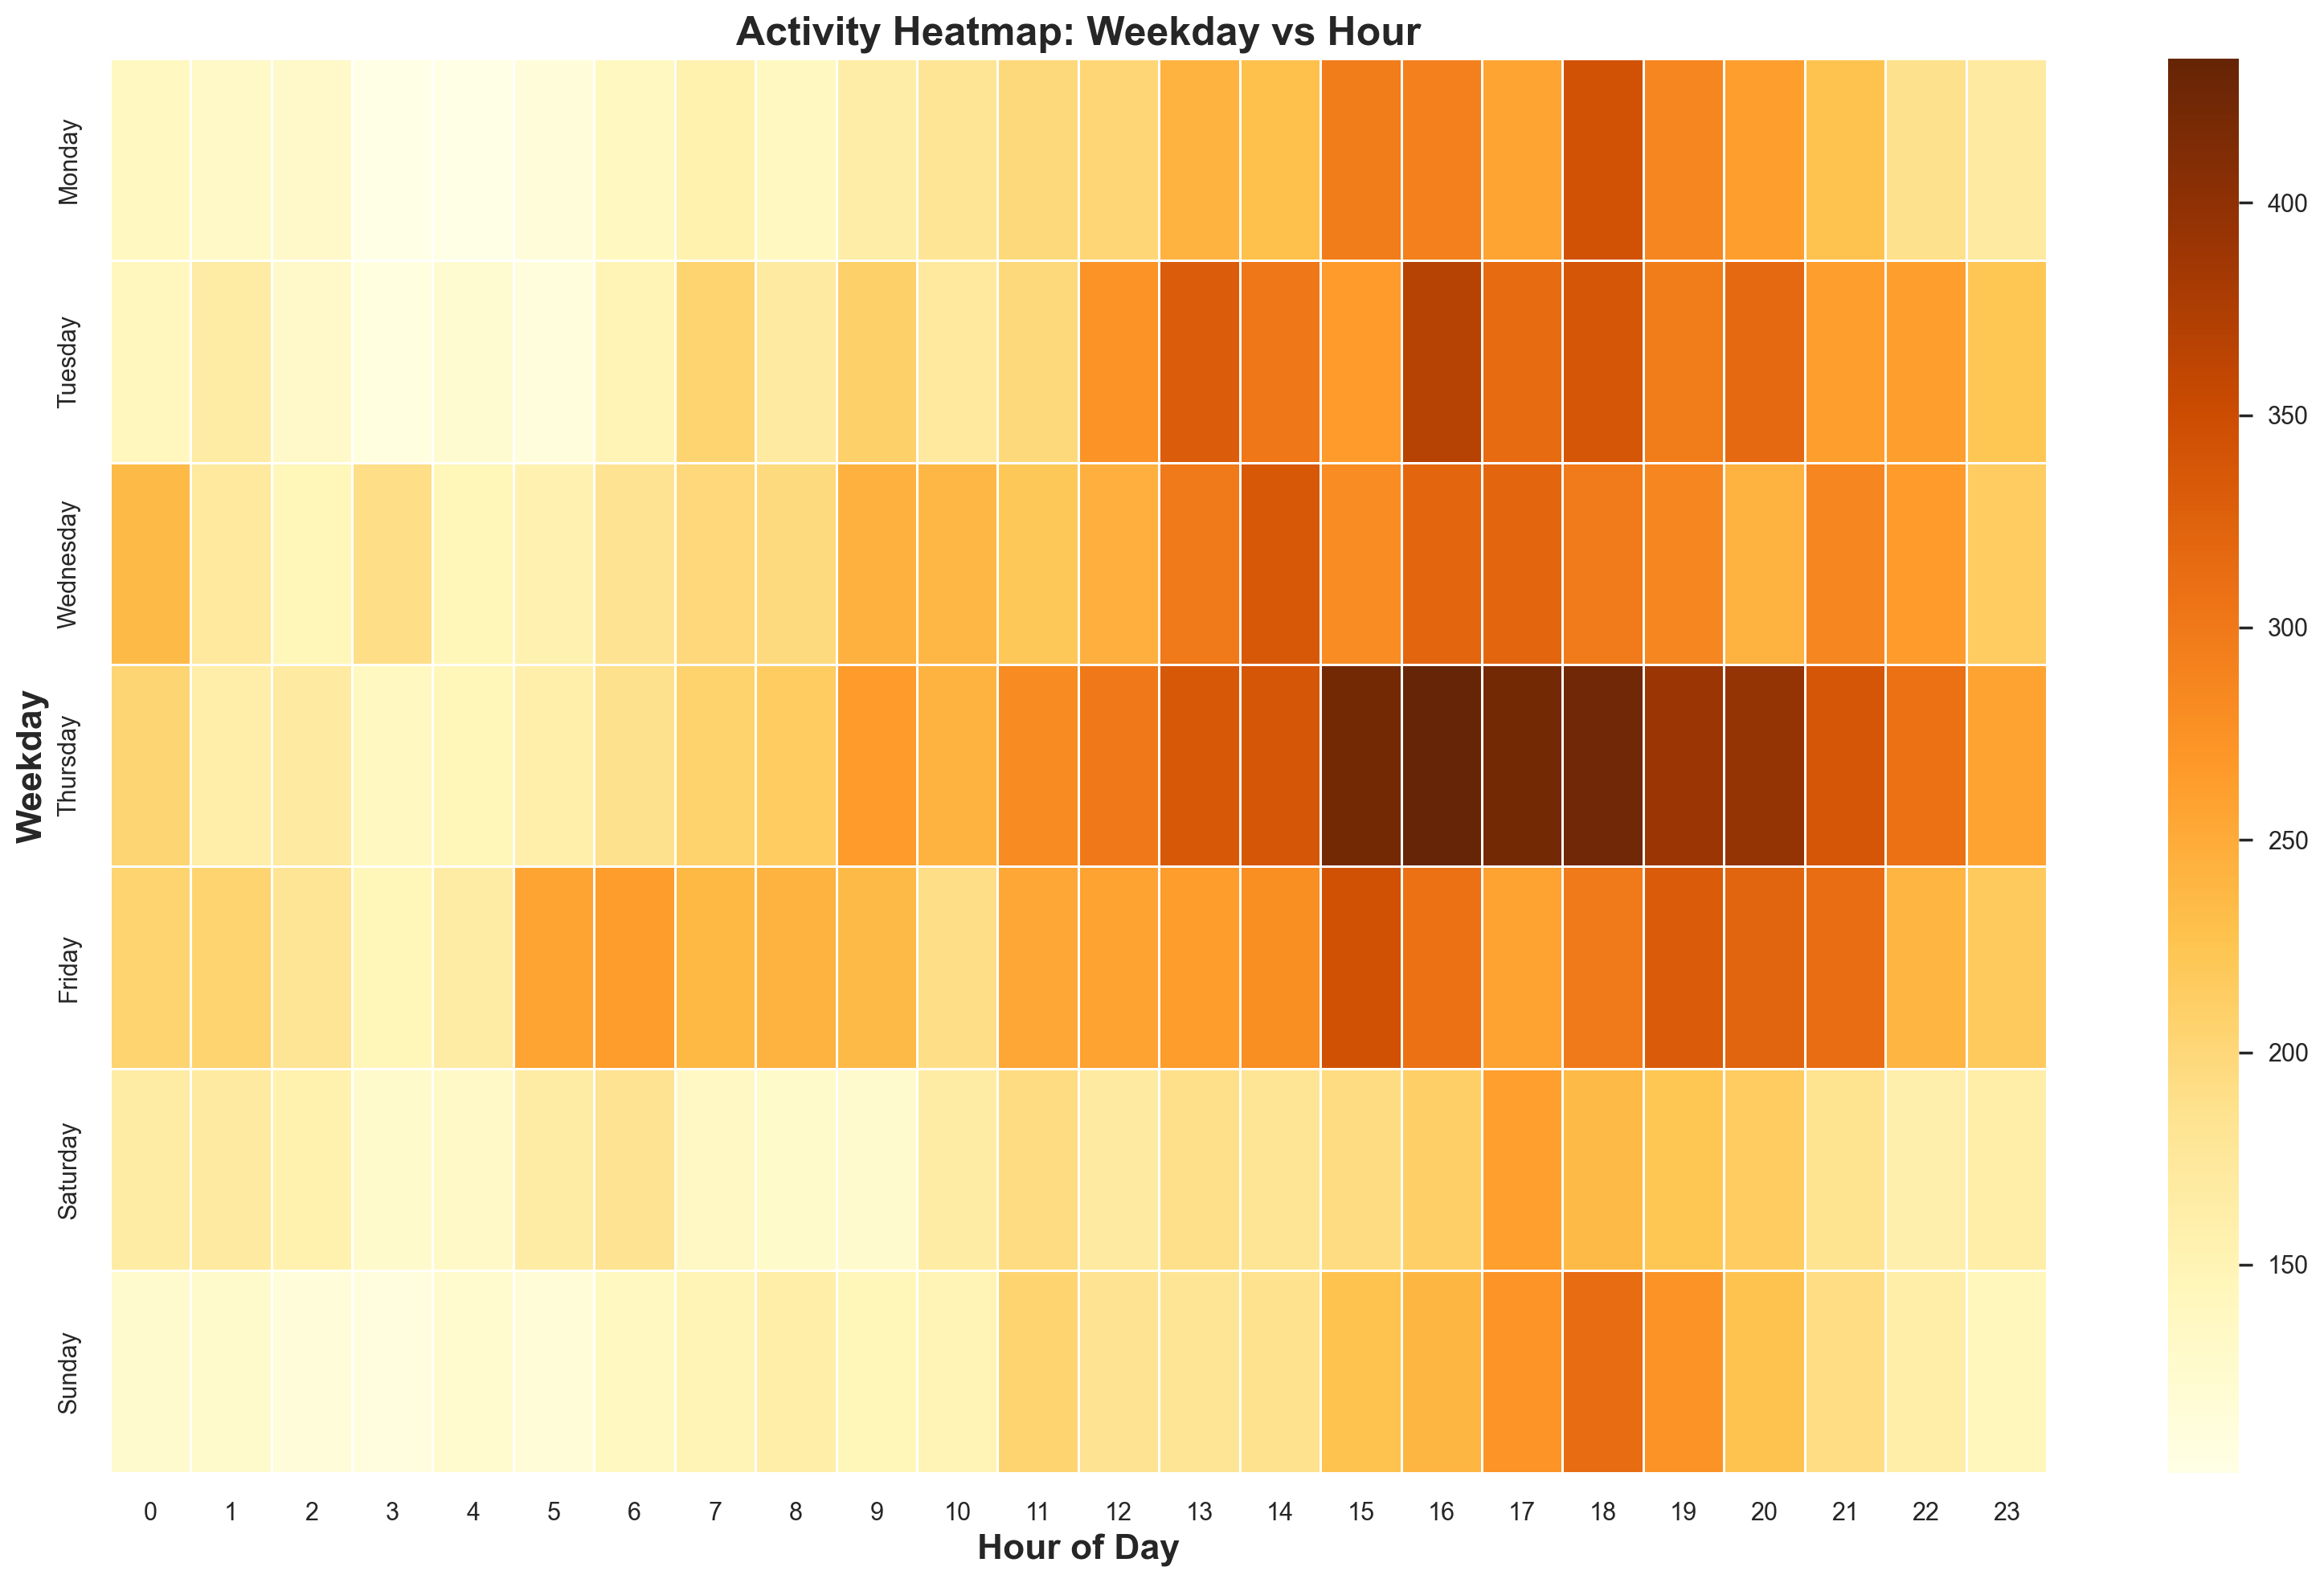

In [64]:
# prepare
dt = pd.to_datetime(df['created'])
df['hour'] = dt.dt.hour
df['weekday'] = dt.dt.day_name()

# pivot
heat = df.pivot_table(
    index='weekday', columns='hour',
    values='id', aggfunc='count'
).reindex([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
])

# plot
# plt.figure(figsize=(12,4))
sns.heatmap(heat, cmap='YlOrBr', linewidths=0.5, linecolor='white')
plt.title("Activity Heatmap: Weekday vs Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()


### Cumulative Growth of Posts

Tracks how your Reddit dataset grows cumulatively day by day.


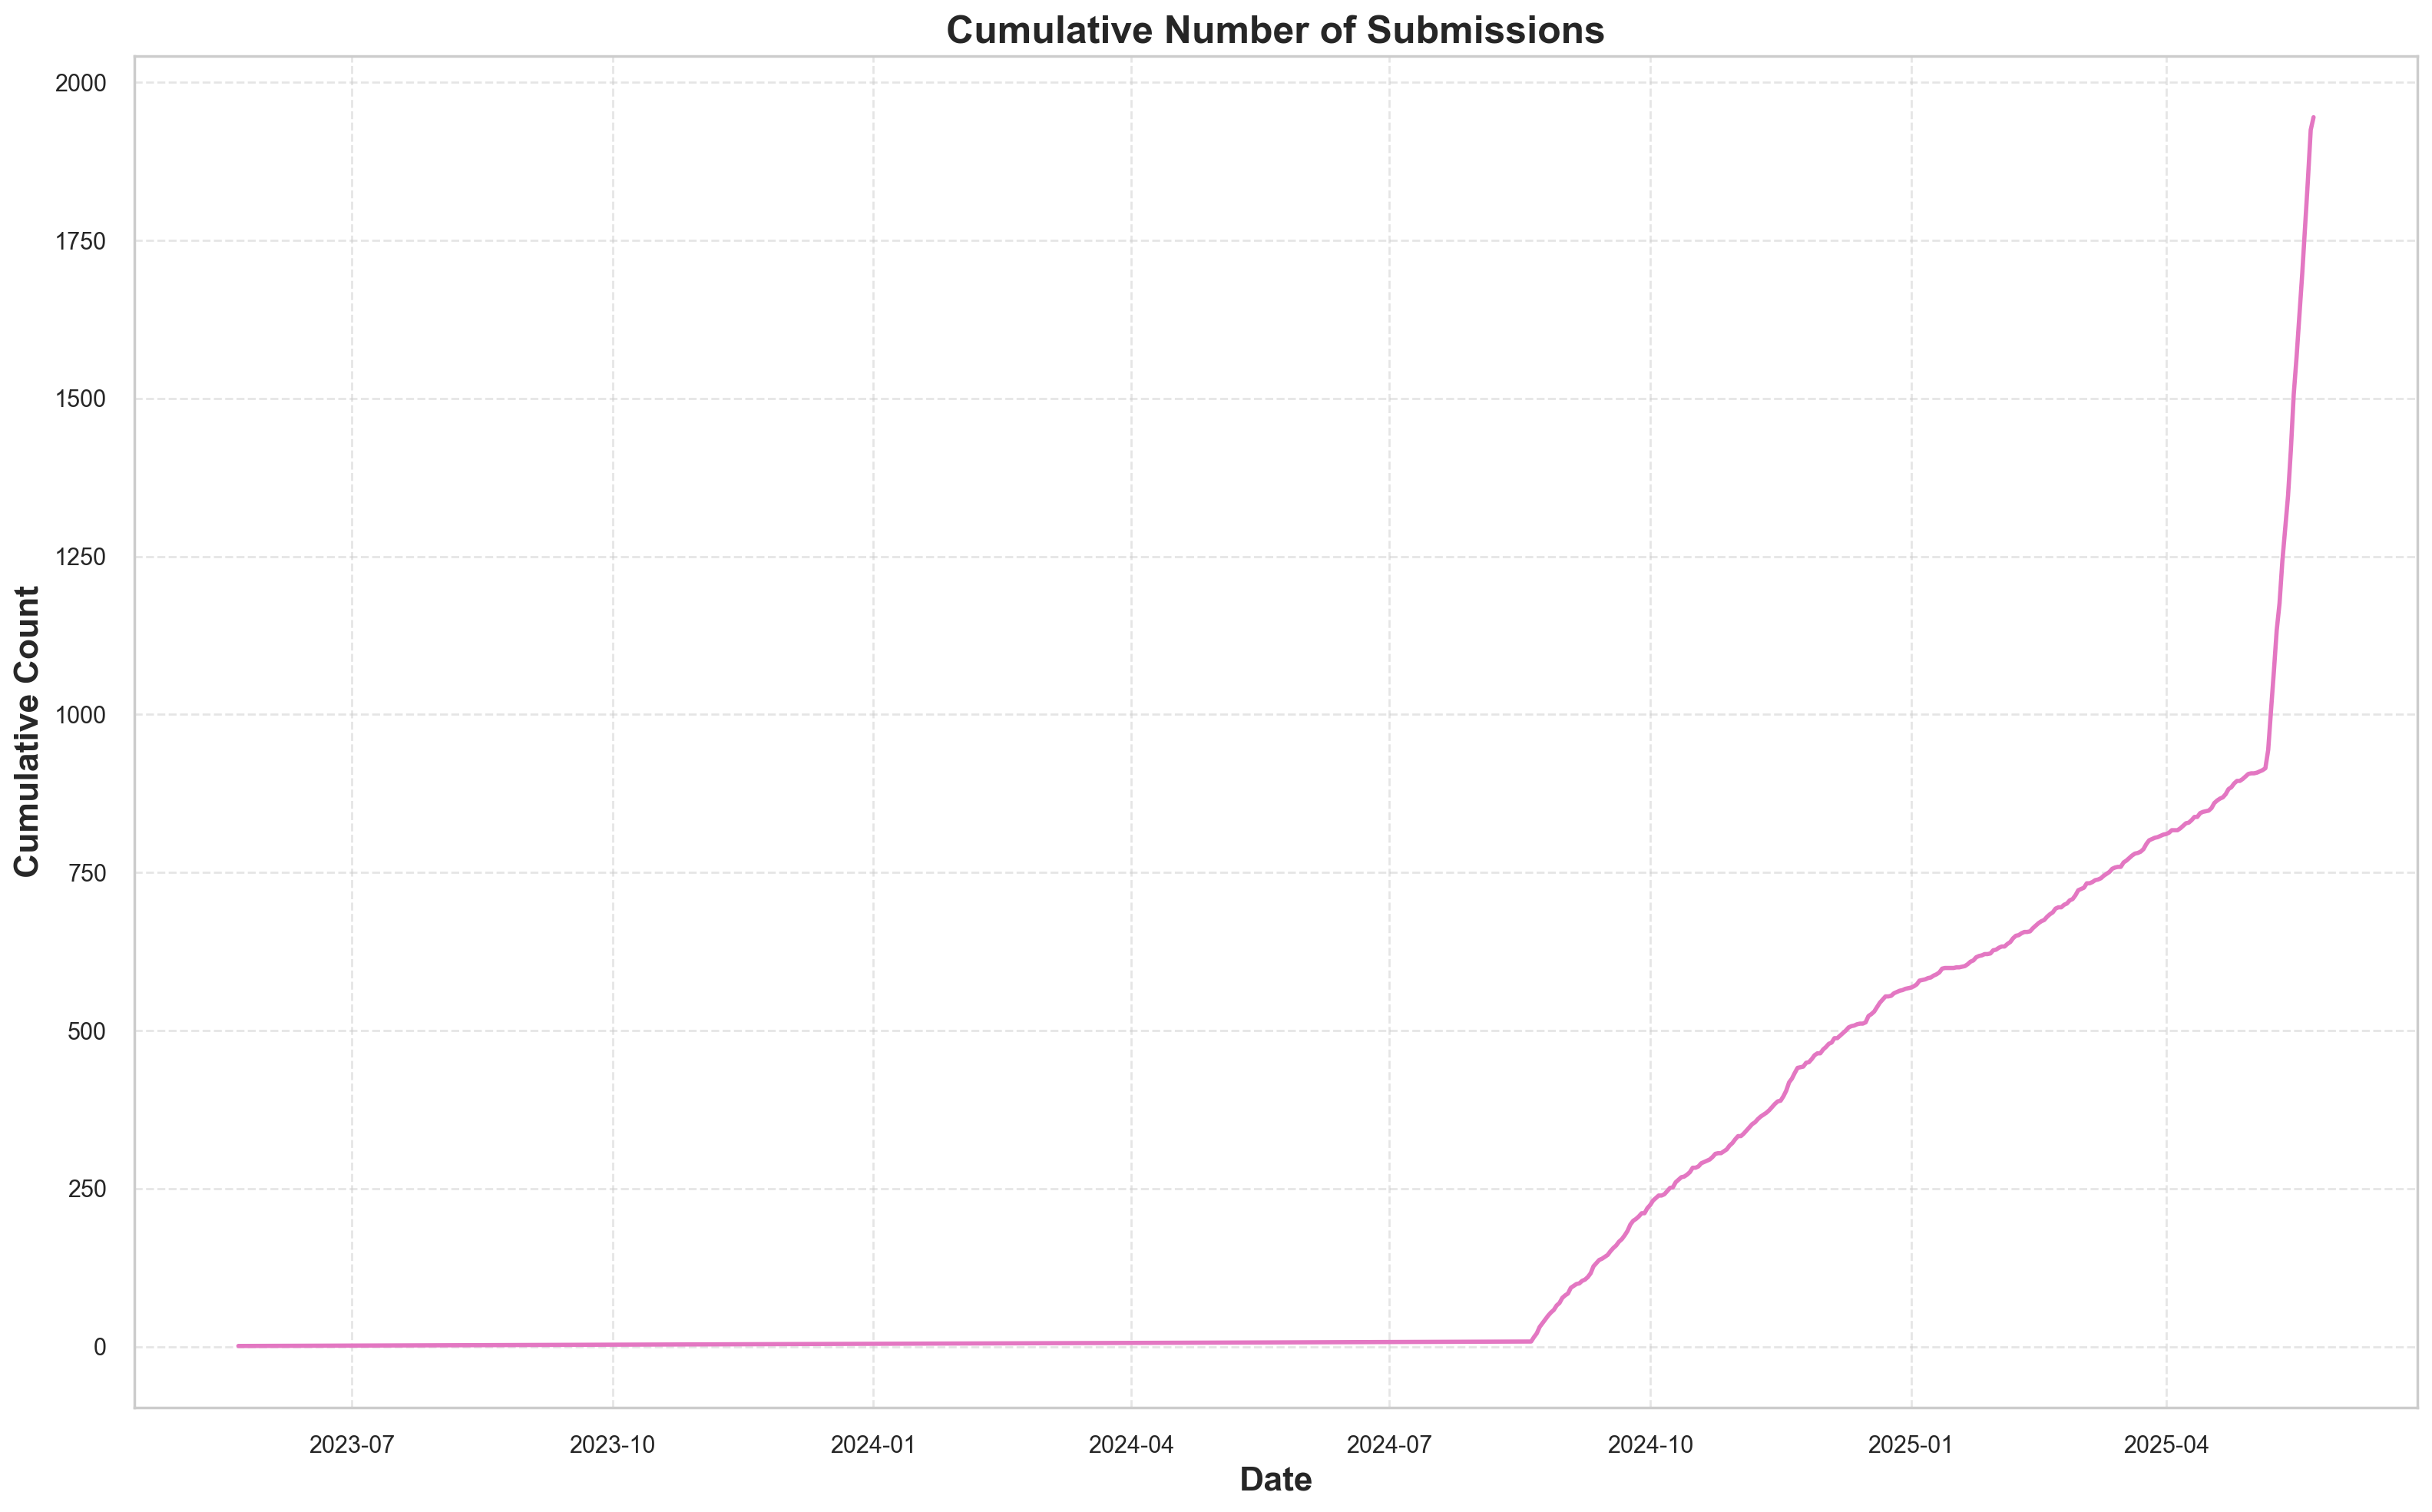

In [65]:
# cumulative sum of daily submissions
cum = daily['submission'].cumsum()

# plt.figure(figsize=(10,4))
cum.plot(color='#e377c2', linewidth=2)
plt.title("Cumulative Number of Submissions")
plt.xlabel("Date")
plt.ylabel("Cumulative Count")
plt.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()
